# Clustering LIME and SHAP

Prior to the application notebook, this is the last notebook, with which we will generate the clusterings on all dataframes - Object DF and Explanation DFs. Thereafter, we will verify if our conditions apply.

In [1]:
#Import packages & Setup
import numpy as np #Linear Algebra
import pandas as pd #Data Frames / Analysis / Structuring / Import
import seaborn as sns #Plotting
import matplotlib.pyplot as plt #Plotting and using inline to not always repeat plt.show() statement
np.set_printoptions(suppress = True) #Suppress scientifc notation
%matplotlib inline

# Overview

- [Data Import & Preparation](#Data-Import-&-Preparation)<p></p>
    - [Object DFs Preparation](#Object-DFs-Preparation)<p></p>
    - [Explanation DFs Preparation](#Explanation-DFs-Preparation)<p></p>
- [Clustering on Object DF](#Clustering-on-Objects)<p></p>
    - [Clustering on object_df](#Clustering-on-object_df)<p></p>
    - [Clustering on sampled_object_df](#Clustering-on-sampled_object_df)<p></p>
- [Clustering on SHAP Explanations DF](#Clustering-on-SHAP-Explanations)<p></p>
    - [SHAP and XGB](#SHAP-and-XGB)<p></p>
    - [SHAP and MLP](#SHAP-and-MLP)<p></p>
- [Clustering on LIME Explanations DF](#Clustering-on-LIME-Explanations)<p></p>
    - [LIME and XGB](#LIME-and-XGB)<p></p>
    - [LIME and MLP](#LIME-and-MLP)<p></p>
- [Cluster Similarity Analysis](#Cluster-Similarity-Analysis)<p></p>
    - [shap_xgb and object_df](#shap_xgb-and-object_df)<p></p>
    - [shap_mlp and sampled_object_df](#shap_mlp-and-sampled_object_df)<p></p>
    - [lime_xgb and object_df](#lime_xgb-and-object_df)<p></p>
    - [lime_mlp and sampled_object_df](#lime_mlp-and-sampled_object_df)<p></p>

## Data Import & Preparation
[[Back to the top]](#Overview)

In the following, we will prepare the objects and explanations dataframes. The objects dfs feature categorical variables and thus require special treatment. On the other hand, the explanation dfs only contain numerical data and thus, need no special preprocessing, other than standardization.

### Object DFs Preparation
[[Back to the top]](#Overview)

<b>1. Importing the object_df (test_df) and creating a one-hot encoding for all caterogical variables, as algorithms such as KMeans do not treat categorical variables correctly. While this significantly increases the dimensionality, it should yield better clustering results.

In [2]:
import pickle
object_df_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Data\\test_df.sav'
object_df = pickle.load(open(object_df_fname, 'rb'))
object_df.head()

,datetime,machineID,volt,rotate,pressure,vibration,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,...,pressure_std_24h,vibration_std_24h,error1_sum_24h,error2_sum_24h,error3_sum_24h,error4_sum_24h,error5_sum_24h,model,age,failure
0,2015-01-03 04:00:00,76,159.077858,463.268115,99.836651,44.177068,175.946148,437.867975,99.109422,41.889142,...,10.680956,4.100460,0.0,0.0,0.0,0.0,0.0,2,10,0
1,2015-01-03 05:00:00,76,168.874939,422.430444,90.680505,42.960636,176.669220,440.562034,98.798174,41.690672,...,10.818075,3.916935,0.0,0.0,0.0,0.0,0.0,2,10,0
2,2015-01-03 06:00:00,76,161.841489,423.787001,108.519650,44.913357,175.283501,438.809223,99.634476,41.645535,...,10.758840,3.871132,0.0,0.0,0.0,0.0,0.0,2,10,0
3,2015-01-03 07:00:00,76,180.679989,397.144210,109.666342,43.701090,175.607685,437.265839,100.141980,42.054792,...,10.938867,3.517384,0.0,0.0,0.0,0.0,0.0,2,10,0
4,2015-01-03 08:00:00,76,174.403680,502.389812,112.473193,39.961410,174.684470,439.194517,100.064502,42.193895,...,10.840127,3.355517,0.0,0.0,0.0,0.0,0.0,2,10,0


In [3]:
#Creating the 1-Hot encodings
model_1h = pd.get_dummies(object_df['model'], prefix = 'model')
age_1h = pd.get_dummies(object_df['age'], prefix = 'age')
failure_1h = pd.get_dummies(object_df['failure'], prefix = 'failure')

In [4]:
#Deleting the categorical variables and merging the new encoded variables to the object_df
object_df_1h = object_df.iloc[:,:19]
object_df_1h = object_df_1h.join(model_1h, how = 'left')
object_df_1h = object_df_1h.join(age_1h, how = 'left')
object_df_1h = object_df_1h.join(failure_1h, how = 'left')
object_df_1h.columns

Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'volt_mean_24h', 'rotate_mean_24h', 'pressure_mean_24h',
       'vibration_mean_24h', 'volt_std_24h', 'rotate_std_24h',
       'pressure_std_24h', 'vibration_std_24h', 'error1_sum_24h',
       'error2_sum_24h', 'error3_sum_24h', 'error4_sum_24h', 'error5_sum_24h',
       'model_1', 'model_2', 'model_3', 'model_4', 'age_1', 'age_2', 'age_5',
       'age_6', 'age_9', 'age_10', 'age_11', 'age_12', 'age_14', 'age_16',
       'age_17', 'age_18', 'age_19', 'age_20', 'failure_0', 'failure_1',
       'failure_2', 'failure_3', 'failure_4'],
      dtype='object')

<b>2. Adding the XGB and MLP predictions to the object_df (not object_df_1h, as that's solely for clustering purposes).

In [5]:
#XGB Class Predictions import (from XGB SKLearn predictions)
xgb_class_pred_skl_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Data\\xgb_class_pred_skl.sav'
xgb_class_pred_skl = pickle.load(open(xgb_class_pred_skl_fname, 'rb'))

In [6]:
#XGB Class Predictions import (from Original - non-scikitlearn predictions)
xgb_class_pred_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Data\\xgb_class_pred.sav'
xgb_class_pred = pickle.load(open(xgb_class_pred_fname, 'rb'))

In [7]:
#MLP Class Predictions import
mlp_class_pred_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Data\\mlp_class_pred.sav'
mlp_class_pred = pickle.load(open(mlp_class_pred_fname, 'rb'))

In [8]:
object_df["XGB_Pred"] = xgb_class_pred #Adding the XGB predictions to the object_df
object_df["XGB_Pred"] = object_df["XGB_Pred"].apply(np.int64) #Converting from float to int
object_df["XGB_Pred_SKL"] = xgb_class_pred_skl #Adding the XGB predictions (from the SKL model) to the object_df
object_df["MLP_Pred"] = mlp_class_pred #Adding the MLP predictions to the object_df
object_df.tail()

,datetime,machineID,volt,rotate,pressure,vibration,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,...,error2_sum_24h,error3_sum_24h,error4_sum_24h,error5_sum_24h,model,age,failure,XGB_Pred,XGB_Pred_SKL,MLP_Pred
218110,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,170.619827,462.234803,101.414987,39.955780,...,0.0,0.0,0.0,0.0,4,5,0,0,0,0
218111,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,172.838745,461.095362,101.396728,39.964090,...,0.0,0.0,0.0,0.0,4,5,0,0,0,0
218112,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,173.778674,455.688781,101.020326,40.420416,...,0.0,0.0,0.0,0.0,4,5,0,0,0,0
218113,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,173.872030,455.376558,101.447889,40.261609,...,0.0,0.0,0.0,0.0,4,5,0,0,0,0
218114,2016-01-01 06:00:00,100,171.336037,496.096870,79.095538,37.845245,173.770428,456.774345,100.507221,40.166266,...,0.0,0.0,0.0,0.0,4,5,0,0,0,0


<b>3. Performing some checks on the object_df.

In [9]:
#Rows where the two XGBoost models reached different prediction results
object_df.loc[(object_df['XGB_Pred'] != object_df['XGB_Pred_SKL'])]

,datetime,machineID,volt,rotate,pressure,vibration,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,...,error2_sum_24h,error3_sum_24h,error4_sum_24h,error5_sum_24h,model,age,failure,XGB_Pred,XGB_Pred_SKL,MLP_Pred
346,2015-01-17 14:00:00,76,173.203229,326.273821,99.431441,39.246593,171.197285,462.963686,124.224138,39.523038,...,0.0,0.0,1.0,0.0,2,10,3,0,3,3
2157,2015-04-03 01:00:00,76,172.739160,509.953949,101.659847,36.212425,171.087577,450.232679,122.048393,38.401661,...,0.0,0.0,1.0,0.0,2,10,3,0,3,3
7906,2015-11-28 14:00:00,76,177.943995,418.621720,101.531792,38.493248,164.602319,451.378702,121.220872,40.665653,...,0.0,0.0,1.0,0.0,2,10,3,0,3,3
15542,2015-10-14 15:00:00,77,139.802303,500.810397,101.229328,33.962292,181.997919,456.669224,98.855777,38.918329,...,0.0,0.0,0.0,0.0,4,12,0,0,1,0
16493,2015-11-23 06:00:00,77,140.958711,484.940880,85.650996,33.593076,189.463398,442.639287,100.442020,40.717737,...,0.0,0.0,0.0,0.0,4,12,0,0,1,1
18391,2015-02-12 05:00:00,78,138.636094,548.537396,105.128463,47.316976,190.393951,442.409957,97.510920,40.732169,...,0.0,0.0,0.0,0.0,4,19,0,0,1,1
18392,2015-02-12 06:00:00,78,159.053760,574.709564,99.422153,37.839970,188.847465,443.305390,96.942442,40.602224,...,0.0,0.0,0.0,0.0,4,19,0,0,1,1
18393,2015-02-12 07:00:00,78,151.271753,391.854267,98.817601,50.495191,186.397342,440.063679,96.491826,40.760052,...,0.0,0.0,0.0,0.0,4,19,0,0,1,1
18394,2015-02-12 08:00:00,78,168.698285,450.153048,107.872407,36.870810,185.886382,439.010609,97.128973,40.611825,...,0.0,0.0,0.0,0.0,4,19,0,0,1,1
26132,2015-12-31 18:00:00,78,204.095469,419.343713,100.340333,39.421300,181.997898,452.280028,95.887287,39.240378,...,0.0,0.0,0.0,0.0,4,19,0,0,1,0


In [10]:
#Rows where both models failed to correctly identify the class
object_df.loc[(object_df['failure'] != object_df['XGB_Pred']) & (object_df['failure'] != object_df['MLP_Pred'])]

,datetime,machineID,volt,rotate,pressure,vibration,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,...,error2_sum_24h,error3_sum_24h,error4_sum_24h,error5_sum_24h,model,age,failure,XGB_Pred,XGB_Pred_SKL,MLP_Pred
338,2015-01-17 06:00:00,76,165.477006,480.618420,119.223531,40.238295,171.507351,471.759392,123.928174,39.832022,...,0.0,0.0,1.0,0.0,2,10,0,3,3,3
362,2015-01-18 06:00:00,76,186.863414,456.272423,124.220615,37.780400,172.382840,453.943290,126.088479,38.224642,...,0.0,0.0,0.0,0.0,2,10,3,0,0,0
698,2015-02-01 06:00:00,76,202.856601,522.761132,96.286938,51.852875,193.275023,457.123182,104.822449,39.396917,...,0.0,0.0,0.0,0.0,2,10,0,1,1,1
722,2015-02-02 06:00:00,76,170.073031,496.212554,100.076951,48.068976,193.491815,454.076607,103.981597,40.697549,...,0.0,0.0,0.0,0.0,2,10,1,0,0,0
1418,2015-03-03 06:00:00,76,180.965075,293.530491,118.252431,44.422265,161.787966,371.850561,97.840834,40.448591,...,1.0,1.0,0.0,0.0,2,10,0,2,2,2
1442,2015-03-04 06:00:00,76,178.467735,365.904233,101.198837,33.637453,169.714366,380.901993,96.241465,40.990514,...,0.0,0.0,0.0,0.0,2,10,2,0,0,0
1778,2015-03-18 06:00:00,76,199.001604,543.956535,103.244884,26.187239,194.127878,450.478884,100.977530,37.663067,...,0.0,0.0,0.0,0.0,2,10,0,1,1,1
1802,2015-03-19 06:00:00,76,189.938725,550.340226,118.611760,44.673651,186.252394,448.990216,100.483399,39.803247,...,0.0,0.0,0.0,0.0,2,10,1,0,0,0
2138,2015-04-02 06:00:00,76,172.696365,504.566906,122.784514,34.001936,165.942992,451.329333,126.927005,39.647499,...,0.0,0.0,1.0,0.0,2,10,0,3,3,3
2162,2015-04-03 06:00:00,76,161.722809,441.209962,147.572525,32.459638,169.547584,454.261467,124.146820,38.581379,...,0.0,0.0,0.0,0.0,2,10,3,0,0,0


In [11]:
object_df.tail()

,datetime,machineID,volt,rotate,pressure,vibration,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,...,error2_sum_24h,error3_sum_24h,error4_sum_24h,error5_sum_24h,model,age,failure,XGB_Pred,XGB_Pred_SKL,MLP_Pred
218110,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,170.619827,462.234803,101.414987,39.955780,...,0.0,0.0,0.0,0.0,4,5,0,0,0,0
218111,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,172.838745,461.095362,101.396728,39.964090,...,0.0,0.0,0.0,0.0,4,5,0,0,0,0
218112,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,173.778674,455.688781,101.020326,40.420416,...,0.0,0.0,0.0,0.0,4,5,0,0,0,0
218113,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,173.872030,455.376558,101.447889,40.261609,...,0.0,0.0,0.0,0.0,4,5,0,0,0,0
218114,2016-01-01 06:00:00,100,171.336037,496.096870,79.095538,37.845245,173.770428,456.774345,100.507221,40.166266,...,0.0,0.0,0.0,0.0,4,5,0,0,0,0


<b>4. Importing the sampled_object_df (sampled_test_df) and first also creating the one-hot encoding for all caterogical variables, then adding the XGB and MLP predictions to the sampled_object_df (not sampled_object_df_1h, as that's solely for clustering purposes).

In [12]:
#Importing the sampled_test_df
sampled_object_df_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Data\\sampled_test_df.sav'
sampled_object_df = pickle.load(open(sampled_object_df_fname, 'rb'))
sampled_object_df.tail()

,datetime,machineID,volt,rotate,pressure,vibration,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,...,pressure_std_24h,vibration_std_24h,error1_sum_24h,error2_sum_24h,error3_sum_24h,error4_sum_24h,error5_sum_24h,model,age,failure
5451,2015-12-14 08:00:00,100,183.043894,490.246046,101.872174,39.674776,169.317152,443.996757,98.780748,37.964020,...,11.484906,3.841780,0.0,0.0,0.0,0.0,0.0,4,5,0
5452,2015-12-17 15:00:00,100,169.486368,414.493492,99.872897,45.358376,172.138431,447.877111,99.390540,41.060120,...,12.653921,6.166981,0.0,0.0,0.0,0.0,0.0,4,5,0
5453,2015-12-23 18:00:00,100,168.998278,422.477946,81.013690,45.482645,165.887035,450.765870,100.407760,39.990272,...,10.634247,3.995090,0.0,0.0,0.0,0.0,0.0,4,5,0
5454,2015-12-27 12:00:00,100,165.330553,382.784933,113.379413,51.022527,170.770310,445.054320,102.972276,40.741444,...,9.258128,5.642378,0.0,0.0,0.0,0.0,0.0,4,5,0
5455,2015-12-31 06:00:00,100,173.774481,462.549988,101.671563,40.133487,166.902351,460.641794,101.634364,39.346934,...,6.856021,5.392136,0.0,0.0,0.0,0.0,0.0,4,5,0


In [13]:
#Creating the 1-Hot encodings
model_1h = pd.get_dummies(sampled_object_df['model'], prefix = 'model')
age_1h = pd.get_dummies(sampled_object_df['age'], prefix = 'age')
failure_1h = pd.get_dummies(sampled_object_df['failure'], prefix = 'failure')

In [14]:
#Deleting the categorical variables and merging the new encoded variables to the sampled_object_df
sampled_object_df_1h = sampled_object_df.iloc[:,:19]
sampled_object_df_1h = sampled_object_df_1h.join(model_1h, how = 'left')
sampled_object_df_1h = sampled_object_df_1h.join(age_1h, how = 'left')
sampled_object_df_1h = sampled_object_df_1h.join(failure_1h, how = 'left')
sampled_object_df_1h.columns

Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'volt_mean_24h', 'rotate_mean_24h', 'pressure_mean_24h',
       'vibration_mean_24h', 'volt_std_24h', 'rotate_std_24h',
       'pressure_std_24h', 'vibration_std_24h', 'error1_sum_24h',
       'error2_sum_24h', 'error3_sum_24h', 'error4_sum_24h', 'error5_sum_24h',
       'model_1', 'model_2', 'model_3', 'model_4', 'age_1', 'age_2', 'age_5',
       'age_6', 'age_9', 'age_10', 'age_11', 'age_12', 'age_14', 'age_16',
       'age_17', 'age_18', 'age_19', 'age_20', 'failure_0', 'failure_1',
       'failure_2', 'failure_3', 'failure_4'],
      dtype='object')

In [15]:
#Adding the predictions for the relevant columns
sampled_object_df = sampled_object_df.merge(object_df[['datetime', 'machineID', 'XGB_Pred', 'XGB_Pred_SKL', 'MLP_Pred']],
                      how = "inner",
                      on = ["datetime", "machineID"])
sampled_object_df.drop_duplicates(inplace = True)
sampled_object_df = sampled_object_df.reset_index(drop = True)
sampled_object_df

,datetime,machineID,volt,rotate,pressure,vibration,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,...,error2_sum_24h,error3_sum_24h,error4_sum_24h,error5_sum_24h,model,age,failure,XGB_Pred,XGB_Pred_SKL,MLP_Pred
0,2015-01-04 02:00:00,76,155.814481,407.510723,103.585001,49.497730,160.754741,445.540769,98.720573,40.803403,...,0.0,0.0,0.0,0.0,2,10,0,0,0,0
1,2015-01-04 08:00:00,76,158.979361,440.687515,90.810568,32.050086,160.584657,445.315406,97.521896,39.817238,...,0.0,0.0,0.0,0.0,2,10,0,0,0,0
2,2015-01-04 12:00:00,76,164.144088,508.937598,81.407381,44.689157,162.315141,454.356336,97.521860,41.668684,...,0.0,0.0,0.0,0.0,2,10,0,0,0,0
3,2015-01-05 21:00:00,76,174.471495,441.128548,92.717511,35.924900,174.614070,439.916015,97.951118,39.949455,...,0.0,0.0,0.0,0.0,2,10,0,0,0,0
4,2015-01-06 06:00:00,76,181.175525,449.692398,110.037863,45.485278,168.202237,444.149225,98.451701,39.908984,...,0.0,0.0,0.0,0.0,2,10,0,0,0,0
5,2015-01-07 21:00:00,76,153.798469,484.170696,98.570191,38.518752,166.748634,450.382220,98.576604,42.003081,...,0.0,0.0,0.0,0.0,2,10,0,0,0,0
6,2015-01-10 10:00:00,76,159.235813,437.231161,97.122713,40.518021,165.951678,432.932747,98.323969,39.486950,...,0.0,0.0,0.0,0.0,2,10,0,0,0,0
7,2015-01-14 23:00:00,76,186.848335,492.996893,98.681008,44.601080,172.437207,447.852631,98.076182,49.658146,...,0.0,0.0,0.0,0.0,2,10,0,0,0,0
8,2015-01-16 10:00:00,76,189.184811,463.532901,122.762403,35.381030,172.938750,459.543743,103.412390,46.060267,...,0.0,0.0,0.0,0.0,2,10,0,0,0,0
9,2015-01-20 02:00:00,76,168.922415,413.751748,81.022340,36.396610,172.519791,438.706383,97.534642,40.668618,...,0.0,0.0,0.0,0.0,2,10,0,0,0,0


<b>5. Performing some checks on the sampled_object_df.

In [16]:
#Rows where the two XGBoost models reached different prediction results
sampled_object_df.loc[(sampled_object_df['XGB_Pred'] != sampled_object_df['XGB_Pred_SKL'])]

,datetime,machineID,volt,rotate,pressure,vibration,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,...,error2_sum_24h,error3_sum_24h,error4_sum_24h,error5_sum_24h,model,age,failure,XGB_Pred,XGB_Pred_SKL,MLP_Pred
478,2015-02-12 07:00:00,78,151.271753,391.854267,98.817601,50.495191,186.397342,440.063679,96.491826,40.760052,...,0.0,0.0,0.0,0.0,4,19,0,0,1,1
2826,2015-11-29 10:00:00,88,173.205499,375.879051,95.445202,48.069116,170.857462,362.765589,98.433383,49.427661,...,1.0,1.0,0.0,1.0,4,14,2,4,2,2
2827,2015-11-29 17:00:00,88,189.174634,499.256993,101.394548,43.276267,171.499556,372.652505,98.447935,48.816458,...,1.0,1.0,0.0,1.0,4,14,2,4,2,2
2828,2015-11-29 22:00:00,88,166.213903,349.189643,105.356907,51.950569,171.680452,363.697545,100.407241,48.686666,...,1.0,1.0,0.0,1.0,4,14,4,4,2,2
3186,2015-08-18 03:00:00,90,172.616898,452.534684,112.470731,39.357833,194.623928,438.207498,123.122812,41.260518,...,0.0,0.0,1.0,0.0,2,2,1,1,3,1
4107,2015-11-18 07:00:00,94,157.405398,332.899320,123.453325,48.598625,164.155648,376.963028,110.685696,50.302992,...,1.0,1.0,0.0,1.0,2,18,2,4,2,2
4108,2015-11-18 08:00:00,94,162.479684,366.353827,134.967065,56.185312,163.471360,373.596519,112.157396,50.682798,...,1.0,1.0,0.0,1.0,2,18,4,4,2,2
4109,2015-11-18 15:00:00,94,171.373419,388.706940,123.156455,46.550590,168.383218,372.584714,120.048006,50.509013,...,1.0,1.0,0.0,1.0,2,18,4,4,2,2
4110,2015-11-18 17:00:00,94,171.411426,298.982412,146.060991,45.762733,167.271073,367.690956,122.983951,50.269158,...,1.0,1.0,0.0,1.0,2,18,4,4,2,2
4355,2015-12-30 23:00:00,95,157.226271,476.667926,95.785713,45.176454,184.425696,426.108909,97.629984,39.518163,...,0.0,0.0,0.0,0.0,2,18,1,0,1,1


In [17]:
#Rows where the XGBoost yielded the wrong prediction
sampled_object_df.loc[(sampled_object_df['failure'] != sampled_object_df['XGB_Pred'])]

,datetime,machineID,volt,rotate,pressure,vibration,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,...,error2_sum_24h,error3_sum_24h,error4_sum_24h,error5_sum_24h,model,age,failure,XGB_Pred,XGB_Pred_SKL,MLP_Pred
60,2015-04-03 06:00:00,76,161.722809,441.209962,147.572525,32.459638,169.547584,454.261467,124.146820,38.581379,...,0.0,0.0,0.0,0.0,2,10,3,0,0,0
873,2015-12-12 06:00:00,79,182.003471,392.510063,100.649992,48.154332,171.503060,441.413186,100.168194,50.621888,...,0.0,0.0,0.0,1.0,3,14,0,4,4,4
997,2015-07-11 06:00:00,80,194.444541,401.799467,81.360077,38.826045,182.885228,378.431926,98.701410,41.627043,...,1.0,1.0,0.0,0.0,3,6,0,2,2,2
1411,2015-04-14 00:00:00,82,206.892616,358.795031,85.840230,43.866996,208.121480,446.871506,98.669093,39.442382,...,0.0,0.0,0.0,0.0,3,11,0,1,1,1
1682,2015-07-14 20:00:00,83,189.298135,440.384062,72.601665,49.557231,191.328073,440.590479,102.131717,49.964794,...,0.0,0.0,0.0,1.0,4,18,4,1,1,1
2441,2015-03-09 04:00:00,87,152.127663,462.781746,143.093300,38.530792,168.476488,445.748030,124.147922,40.453684,...,0.0,0.0,1.0,0.0,2,12,0,3,3,3
2442,2015-03-09 12:00:00,87,163.732280,320.074725,124.883124,47.253778,167.110526,446.899085,122.624728,41.740988,...,0.0,0.0,1.0,0.0,2,12,0,3,3,3
2443,2015-03-09 19:00:00,87,170.881194,524.068479,124.469324,44.705415,167.118194,451.353181,123.975237,42.597338,...,0.0,0.0,1.0,0.0,2,12,0,3,3,3
2778,2015-08-31 12:00:00,88,171.842228,405.841512,83.228978,50.545018,172.609784,376.633343,96.533579,48.459389,...,1.0,1.0,0.0,1.0,4,14,2,4,4,2
2826,2015-11-29 10:00:00,88,173.205499,375.879051,95.445202,48.069116,170.857462,362.765589,98.433383,49.427661,...,1.0,1.0,0.0,1.0,4,14,2,4,2,2


In [18]:
#Rows where the MLP yielded the wrong prediction
sampled_object_df.loc[(sampled_object_df['failure'] != sampled_object_df['MLP_Pred'])]

,datetime,machineID,volt,rotate,pressure,vibration,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,...,error2_sum_24h,error3_sum_24h,error4_sum_24h,error5_sum_24h,model,age,failure,XGB_Pred,XGB_Pred_SKL,MLP_Pred
60,2015-04-03 06:00:00,76,161.722809,441.209962,147.572525,32.459638,169.547584,454.261467,124.146820,38.581379,...,0.0,0.0,0.0,0.0,2,10,3,0,0,0
478,2015-02-12 07:00:00,78,151.271753,391.854267,98.817601,50.495191,186.397342,440.063679,96.491826,40.760052,...,0.0,0.0,0.0,0.0,4,19,0,0,1,1
873,2015-12-12 06:00:00,79,182.003471,392.510063,100.649992,48.154332,171.503060,441.413186,100.168194,50.621888,...,0.0,0.0,0.0,1.0,3,14,0,4,4,4
997,2015-07-11 06:00:00,80,194.444541,401.799467,81.360077,38.826045,182.885228,378.431926,98.701410,41.627043,...,1.0,1.0,0.0,0.0,3,6,0,2,2,2
1411,2015-04-14 00:00:00,82,206.892616,358.795031,85.840230,43.866996,208.121480,446.871506,98.669093,39.442382,...,0.0,0.0,0.0,0.0,3,11,0,1,1,1
1682,2015-07-14 20:00:00,83,189.298135,440.384062,72.601665,49.557231,191.328073,440.590479,102.131717,49.964794,...,0.0,0.0,0.0,1.0,4,18,4,1,1,1
1889,2015-07-02 21:00:00,84,190.857850,469.193047,104.601084,37.771298,180.254370,444.370201,98.617140,38.955967,...,0.0,0.0,0.0,0.0,3,9,0,0,0,1
2441,2015-03-09 04:00:00,87,152.127663,462.781746,143.093300,38.530792,168.476488,445.748030,124.147922,40.453684,...,0.0,0.0,1.0,0.0,2,12,0,3,3,3
2442,2015-03-09 12:00:00,87,163.732280,320.074725,124.883124,47.253778,167.110526,446.899085,122.624728,41.740988,...,0.0,0.0,1.0,0.0,2,12,0,3,3,3
2443,2015-03-09 19:00:00,87,170.881194,524.068479,124.469324,44.705415,167.118194,451.353181,123.975237,42.597338,...,0.0,0.0,1.0,0.0,2,12,0,3,3,3


In [19]:
sampled_object_df.tail()

,datetime,machineID,volt,rotate,pressure,vibration,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,...,error2_sum_24h,error3_sum_24h,error4_sum_24h,error5_sum_24h,model,age,failure,XGB_Pred,XGB_Pred_SKL,MLP_Pred
5451,2015-12-14 08:00:00,100,183.043894,490.246046,101.872174,39.674776,169.317152,443.996757,98.780748,37.964020,...,0.0,0.0,0.0,0.0,4,5,0,0,0,0
5452,2015-12-17 15:00:00,100,169.486368,414.493492,99.872897,45.358376,172.138431,447.877111,99.390540,41.060120,...,0.0,0.0,0.0,0.0,4,5,0,0,0,0
5453,2015-12-23 18:00:00,100,168.998278,422.477946,81.013690,45.482645,165.887035,450.765870,100.407760,39.990272,...,0.0,0.0,0.0,0.0,4,5,0,0,0,0
5454,2015-12-27 12:00:00,100,165.330553,382.784933,113.379413,51.022527,170.770310,445.054320,102.972276,40.741444,...,0.0,0.0,0.0,0.0,4,5,0,0,0,0
5455,2015-12-31 06:00:00,100,173.774481,462.549988,101.671563,40.133487,166.902351,460.641794,101.634364,39.346934,...,0.0,0.0,0.0,0.0,4,5,0,0,0,0


In [20]:
sampled_object_df['failure'].value_counts()

0    5332
2      41
3      29
1      27
4      27
Name: failure, dtype: int64

<b>6. Now, we still need to standardize the above dataframes (only the numerical features of the object_df_1h and sampled_object_df_1h, not the 1-Hot encoded ones), to reach a better clustering result.

In [21]:
#Starting with the object_df_1h
#Saving the beginning and the end of the df that we won't transform in variables
object_df_1h_start = object_df_1h.iloc[:,:2]
object_df_1h_end = object_df_1h.iloc[:,14:]

#Importing the StandardScaler and performing the standardization 
#Standardization rescales data to have a mean (μ) of 0 and standard deviation (σ) of 1 (unit variance)
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(object_df_1h.iloc[:,2:14].values)

scaled_object_df_1h = object_df_1h_start.copy()
scaled_object_df_1h = scaled_object_df_1h.join(pd.DataFrame(scaled_features,
                                                            index = object_df_1h.index,
                                                            columns = object_df_1h.iloc[:,2:14].columns),
                                                            how = 'left')
scaled_object_df_1h = scaled_object_df_1h.join(object_df_1h_end, how = 'left')
scaled_object_df_1h.tail()

,datetime,machineID,volt,rotate,pressure,vibration,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,...,age_16,age_17,age_18,age_19,age_20,failure_0,failure_1,failure_2,failure_3,failure_4
218110,2016-01-01 02:00:00,100,0.560732,-0.971281,0.118727,1.932886,-0.024483,0.849963,0.092681,-0.209505,...,0,0,0,0,0,1,0,0,0,0
218111,2016-01-01 03:00:00,100,1.217034,-0.006281,-0.250940,-0.980059,0.444437,0.788274,0.088914,-0.205476,...,0,0,0,0,0,1,0,0,0,0
218112,2016-01-01 04:00:00,100,1.401806,0.024164,-0.615001,1.475459,0.643071,0.495562,0.011243,0.015823,...,0,0,0,0,0,1,0,0,0,0
218113,2016-01-01 05:00:00,100,-0.339502,-0.620205,0.279754,0.827807,0.662800,0.478659,0.099471,-0.061191,...,0,0,0,0,0,1,0,0,0,0
218114,2016-01-01 06:00:00,100,0.038360,0.937971,-1.967472,-0.473343,0.641329,0.554335,-0.094637,-0.107429,...,0,0,0,0,0,1,0,0,0,0


In [22]:
scaled_object_df_1h.columns

Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'volt_mean_24h', 'rotate_mean_24h', 'pressure_mean_24h',
       'vibration_mean_24h', 'volt_std_24h', 'rotate_std_24h',
       'pressure_std_24h', 'vibration_std_24h', 'error1_sum_24h',
       'error2_sum_24h', 'error3_sum_24h', 'error4_sum_24h', 'error5_sum_24h',
       'model_1', 'model_2', 'model_3', 'model_4', 'age_1', 'age_2', 'age_5',
       'age_6', 'age_9', 'age_10', 'age_11', 'age_12', 'age_14', 'age_16',
       'age_17', 'age_18', 'age_19', 'age_20', 'failure_0', 'failure_1',
       'failure_2', 'failure_3', 'failure_4'],
      dtype='object')

In [23]:
scaled_object_df_1h.describe()

,machineID,volt,rotate,pressure,vibration,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_std_24h,...,age_16,age_17,age_18,age_19,age_20,failure_0,failure_1,failure_2,failure_3,failure_4
count,218115.000000,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,...,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000
mean,88.003411,6.534092e-16,-8.535750e-16,-2.065074e-15,-1.799344e-18,4.422872e-15,-1.850082e-15,-1.280927e-15,5.107179e-16,-2.085607e-15,...,0.039956,0.079912,0.160154,0.039956,0.040176,0.977663,0.004952,0.007372,0.005172,0.004841
std,7.210103,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,0.195856,0.271157,0.366750,0.195856,0.196372,0.147777,0.070193,0.085545,0.071728,0.069412
min,76.000000,-4.668082e+00,-5.288998e+00,-4.209300e+00,-4.748737e+00,-2.861938e+00,-9.785440e+00,-2.043650e+00,-2.204895e+00,-3.685106e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,82.000000,-6.758662e-01,-6.480388e-01,-6.672311e-01,-6.718842e-01,-5.745994e-01,-2.696549e-01,-4.651236e-01,-5.038978e-01,-6.866722e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,88.000000,-9.651857e-03,1.906732e-02,-3.947233e-02,-2.979150e-02,-1.194623e-01,1.471793e-01,-1.697402e-01,-1.504493e-01,-2.501622e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,94.000000,6.606146e-01,6.752087e-01,6.025113e-01,6.335082e-01,3.579424e-01,5.356660e-01,1.444147e-01,2.193545e-01,6.481391e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,4.884292e+00,3.958743e+00,6.262825e+00,5.838039e+00,8.474112e+00,2.822269e+00,1.059585e+01,9.981582e+00,5.608288e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
#Now doing the same for the sampled_object_df_1h
#Saving the beginning and the end of the df that we won't transform in variables
sampled_object_df_1h_start = sampled_object_df_1h.iloc[:,:2]
sampled_object_df_1h_end = sampled_object_df_1h.iloc[:,14:]

#Importing the StandardScaler and performing the standardization 
#Standardization rescales data to have a mean (μ) of 0 and standard deviation (σ) of 1 (unit variance)
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(sampled_object_df_1h.iloc[:,2:14].values)

scaled_sampled_object_df_1h = sampled_object_df_1h_start.copy()
scaled_sampled_object_df_1h = scaled_sampled_object_df_1h.join(pd.DataFrame(scaled_features,
                                                            index = sampled_object_df_1h.index,
                                                            columns = sampled_object_df_1h.iloc[:,2:14].columns),
                                                            how = 'left')
scaled_sampled_object_df_1h = scaled_sampled_object_df_1h.join(sampled_object_df_1h_end, how = 'left')
scaled_sampled_object_df_1h.tail()

,datetime,machineID,volt,rotate,pressure,vibration,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,...,age_16,age_17,age_18,age_19,age_20,failure_0,failure_1,failure_2,failure_3,failure_4
5451,2015-12-14 08:00:00,100,0.792751,0.859769,0.086686,-0.133378,-0.299058,-0.124911,-0.454132,-1.161899,...,0,0,0,0,0,1,0,0,0,0
5452,2015-12-17 15:00:00,100,-0.086995,-0.599532,-0.094925,0.929507,0.289059,0.083750,-0.328877,0.288287,...,0,0,0,0,0,1,0,0,0,0
5453,2015-12-23 18:00:00,100,-0.118667,-0.445719,-1.808064,0.952747,-1.014093,0.239089,-0.119934,-0.212820,...,0,0,0,0,0,1,0,0,0,0
5454,2015-12-27 12:00:00,100,-0.356665,-1.210368,1.131984,1.988755,0.003864,-0.068042,0.406833,0.139022,...,0,0,0,0,0,1,0,0,0,0
5455,2015-12-31 06:00:00,100,0.191260,0.326231,0.068463,-0.047595,-0.802443,0.770153,0.132018,-0.514154,...,0,0,0,0,0,1,0,0,0,0


In [25]:
scaled_sampled_object_df_1h.columns

Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'volt_mean_24h', 'rotate_mean_24h', 'pressure_mean_24h',
       'vibration_mean_24h', 'volt_std_24h', 'rotate_std_24h',
       'pressure_std_24h', 'vibration_std_24h', 'error1_sum_24h',
       'error2_sum_24h', 'error3_sum_24h', 'error4_sum_24h', 'error5_sum_24h',
       'model_1', 'model_2', 'model_3', 'model_4', 'age_1', 'age_2', 'age_5',
       'age_6', 'age_9', 'age_10', 'age_11', 'age_12', 'age_14', 'age_16',
       'age_17', 'age_18', 'age_19', 'age_20', 'failure_0', 'failure_1',
       'failure_2', 'failure_3', 'failure_4'],
      dtype='object')

In [26]:
scaled_sampled_object_df_1h.describe()

,machineID,volt,rotate,pressure,vibration,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_std_24h,...,age_16,age_17,age_18,age_19,age_20,failure_0,failure_1,failure_2,failure_3,failure_4
count,5456.000000,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,...,5456.000000,5456.00000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000
mean,87.966459,5.907624e-16,1.063696e-15,3.450955e-16,-1.357515e-15,2.609919e-16,-2.843563e-15,5.493630e-17,-5.634138e-16,-3.659707e-16,...,0.038490,0.07588,0.164223,0.042705,0.041606,0.977273,0.004949,0.007515,0.005315,0.004949
std,7.239960,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,...,0.192393,0.26483,0.370512,0.202210,0.199704,0.149046,0.070179,0.086369,0.072718,0.070179
min,76.000000,-3.646907e+00,-4.251175e+00,-3.843556e+00,-3.809749e+00,-2.507781e+00,-7.445666e+00,-1.972803e+00,-2.055571e+00,-3.175479e+00,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,82.000000,-6.627065e-01,-6.656929e-01,-6.809518e-01,-6.660321e-01,-5.737064e-01,-2.667126e-01,-4.724475e-01,-4.981971e-01,-6.940354e-01,...,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,88.000000,-1.148166e-02,1.210862e-02,-3.340994e-02,-3.357556e-02,-1.163230e-01,1.468606e-01,-1.759094e-01,-1.619035e-01,-1.797867e-02,...,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,94.000000,6.620589e-01,6.851427e-01,6.002842e-01,6.338144e-01,3.464024e-01,5.406716e-01,1.396273e-01,2.015013e-01,6.465368e-01,...,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,4.557713e+00,3.428205e+00,4.315231e+00,4.736544e+00,7.790008e+00,2.214112e+00,5.903341e+00,7.949884e+00,4.047773e+00,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<b>In sum, we now have the following dataframes:</b>
- object_df: Has no 1-Hot encoding for categorical variables, but instead it has columns 'XGB_Pred', 'XGB_Pred_SKL', 'MLP_Pred'
- scaled_object_df_1h: Has a 1-Hot encoding for all categorical variables, however, it does not have columns 'XGB_Pred', 'XGB_Pred_SKL', 'MLP_Pred'
- sampled_object_df: Has no 1-Hot encoding for categorical variables, but instead it has columns 'XGB_Pred', 'XGB_Pred_SKL', 'MLP_Pred' (sample only!)
- scaled_sampled_object_df_1h: Has a 1-Hot encoding for all categorical variables, however, it does not have columns 'XGB_Pred', 'XGB_Pred_SKL', 'MLP_Pred' (sample only!)

### Explanation DFs Preparation
[[Back to the top]](#Overview)

<b>Importing the following explanation dataframes:</b>
- LIME Explanations from predictions with XGB (Entire test_df)
- LIME Explanations from predictions with MLP (sampled_test_df)
- SHAP Explanations from predictions with XGB (Entire test_df)
- SHAP Explanations from predictions with MLP (sampled_test_df)

<b>1. Importing and preprocessing lime_xgb_explanations:

In [27]:
#Importing LIME explanations from XGB test_df and converting values to float
lime_xgb_explanations_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Data\\xgb_lime_results.sav'
lime_xgb_explanations = pickle.load(open(lime_xgb_explanations_fname, 'rb'))
lime_xgb_explanations = lime_xgb_explanations.astype(float)
lime_xgb_explanations.describe()

,volt_lime,rotate_lime,pressure_lime,vibration_lime,volt_mean_24h_lime,rotate_mean_24h_lime,pressure_mean_24h_lime,vibration_mean_24h_lime,volt_std_24h_lime,rotate_std_24h_lime,pressure_std_24h_lime,vibration_std_24h_lime,error1_sum_24h_lime,error2_sum_24h_lime,error3_sum_24h_lime,error4_sum_24h_lime,error5_sum_24h_lime,model_lime,age_lime,score_lime
count,218111.000000,218111.000000,218112.000000,218113.000000,218114.000000,218115.000000,218115.000000,218111.000000,218111.000000,218112.000000,218112.000000,218112.000000,218115.000000,218111.000000,218110.000000,218113.000000,218113.000000,218110.000000,218112.000000,218108.000000
mean,0.000696,0.000831,0.000761,0.000660,0.005040,0.003425,0.004137,0.001078,0.000318,0.000344,0.000314,0.000408,0.007739,0.000519,0.000868,0.006016,0.006652,0.001336,0.002648,0.043199
std,0.005753,0.007575,0.006929,0.006322,0.010362,0.012355,0.011117,0.007792,0.004539,0.003219,0.003908,0.003826,0.011058,0.007762,0.008263,0.010560,0.011363,0.015447,0.019296,0.108855
min,-0.079850,-0.024633,-0.090745,-0.042192,-0.123935,-0.059554,-0.173027,-0.118117,-0.100247,-0.042144,-0.046719,-0.034860,-0.089985,-0.029273,-0.035787,-0.064666,-0.050588,-0.113792,-0.077237,0.002593
25%,-0.000188,-0.000163,-0.000251,-0.000432,0.003282,0.002150,0.001884,0.000165,-0.000411,-0.000262,-0.000251,-0.000255,0.002869,-0.000338,-0.000092,0.001115,0.001197,-0.000364,-0.000056,0.018726
50%,0.000135,0.000099,0.000043,0.000020,0.004371,0.002693,0.003096,0.000476,-0.000126,-0.000005,-0.000066,0.000111,0.005450,-0.000168,0.000146,0.003111,0.003346,0.000067,0.000258,0.022838
75%,0.000391,0.000350,0.000398,0.000508,0.005857,0.003297,0.004793,0.000815,0.000269,0.000255,0.000181,0.000359,0.009597,-0.000026,0.000395,0.007313,0.007909,0.000433,0.000603,0.030922
max,0.206425,0.189176,0.295394,0.226289,0.392285,0.304373,0.333461,0.278651,0.242600,0.213194,0.196909,0.250445,0.388429,0.211143,0.324552,0.173720,0.240049,0.367531,0.392088,0.972452


In [28]:
#Applying the StandardScaler to the data for the clustering
#Standardization rescales data to have a mean (μ) of 0 and standard deviation (σ) of 1 (unit variance)
lime_xgb_explanations_scores = lime_xgb_explanations['score_lime']

#Substitute NaN values with 0
lime_xgb_explanations = lime_xgb_explanations.fillna(0)

#Importing the StandardScaler and performing the standardization 
#Standardization rescales data to have a mean (μ) of 0 and standard deviation (σ) of 1 (unit variance)
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(lime_xgb_explanations.iloc[:,:-1].dropna().values)

scaled_lime_xgb_explanations = pd.DataFrame(scaled_features,
                                            index = lime_xgb_explanations.index,
                                            columns = lime_xgb_explanations.iloc[:,0:-1].columns)

scaled_lime_xgb_explanations = scaled_lime_xgb_explanations.join(lime_xgb_explanations_scores, how = 'left')
scaled_lime_xgb_explanations.tail()

,volt_lime,rotate_lime,pressure_lime,vibration_lime,volt_mean_24h_lime,rotate_mean_24h_lime,pressure_mean_24h_lime,vibration_mean_24h_lime,volt_std_24h_lime,rotate_std_24h_lime,pressure_std_24h_lime,vibration_std_24h_lime,error1_sum_24h_lime,error2_sum_24h_lime,error3_sum_24h_lime,error4_sum_24h_lime,error5_sum_24h_lime,model_lime,age_lime,score_lime
218110,-0.096950,-0.127036,-0.077768,-0.111784,-0.165858,-0.093295,-0.237236,-0.093403,-0.044878,-0.065585,-0.089646,-0.078462,-0.489713,-0.051619,-0.087325,-0.559448,-0.461566,-0.071789,-0.138112,0.017135
218111,-0.118474,-0.072101,-0.138913,-0.078885,0.041136,-0.048455,-0.089327,-0.065115,-0.118219,-0.045830,-0.050991,-0.032180,-0.257245,-0.058852,-0.067670,-0.448396,-0.400063,-0.061122,-0.113101,0.018430
218112,-0.115661,-0.071908,-0.133654,-0.233183,-0.077350,-0.044332,-0.161974,-0.085651,-0.038146,0.006093,-0.108536,-0.081268,-0.554141,-0.086634,-0.075740,-0.532454,-0.095173,-0.060293,-0.130851,0.016690
218113,-0.104137,-0.095359,-0.078223,-0.107417,-0.210364,-0.053888,-0.279344,-0.085527,-0.063019,-0.080356,-0.093024,-0.058082,-0.569932,-0.046188,-0.090429,-0.531689,-0.387684,-0.070623,-0.133902,0.019052
218114,-0.213025,-0.140156,-0.171079,-0.159105,-0.168683,0.076941,-0.260985,0.022726,-0.124747,-0.151846,-0.120716,0.049195,-0.563921,-0.060830,-0.079786,-0.346594,2.225599,-0.048726,-0.116220,0.042749


In [29]:
scaled_lime_xgb_explanations.describe()

,volt_lime,rotate_lime,pressure_lime,vibration_lime,volt_mean_24h_lime,rotate_mean_24h_lime,pressure_mean_24h_lime,vibration_mean_24h_lime,volt_std_24h_lime,rotate_std_24h_lime,pressure_std_24h_lime,vibration_std_24h_lime,error1_sum_24h_lime,error2_sum_24h_lime,error3_sum_24h_lime,error4_sum_24h_lime,error5_sum_24h_lime,model_lime,age_lime,score_lime
count,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,218108.000000
mean,7.229060e-18,7.986032e-17,3.135013e-16,2.182156e-17,2.813415e-18,1.181003e-16,1.237198e-16,1.839668e-16,-7.794225e-17,-1.428949e-16,-1.258014e-17,-4.569340e-17,2.944765e-17,-8.972868e-17,1.067954e-16,7.249075e-16,2.815833e-17,-1.425914e-16,7.051378e-17,0.043199
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.108855
min,-1.399968e+01,-3.361702e+00,-1.320636e+01,-6.778749e+00,-1.244666e+01,-5.097347e+00,-1.593626e+01,-1.529766e+01,-2.215576e+01,-1.319949e+01,-1.203440e+01,-9.218521e+00,-8.837555e+00,-3.838055e+00,-4.436360e+00,-6.693308e+00,-5.037618e+00,-7.453078e+00,-4.139921e+00,0.002593
25%,-1.536697e-01,-1.311504e-01,-1.461079e-01,-1.727366e-01,-1.696771e-01,-1.032265e-01,-2.026050e-01,-1.171407e-01,-1.606234e-01,-1.881225e-01,-1.444825e-01,-1.732907e-01,-4.404596e-01,-1.104629e-01,-1.161661e-01,-4.640827e-01,-4.800918e-01,-1.100556e-01,-1.401544e-01,0.018726
50%,-9.748406e-02,-9.666040e-02,-1.036245e-01,-1.012551e-01,-6.452554e-02,-5.928522e-02,-9.356020e-02,-7.731499e-02,-9.782270e-02,-1.083841e-01,-9.724694e-02,-7.760018e-02,-2.070641e-01,-8.849956e-02,-8.737951e-02,-2.750726e-01,-2.909632e-01,-8.213630e-02,-1.238590e-01,0.022838
75%,-5.291945e-02,-6.345517e-02,-5.244141e-02,-2.407668e-02,7.885934e-02,-1.041213e-02,5.901822e-02,-3.373004e-02,-1.099209e-02,-2.744302e-02,-3.384448e-02,-1.284846e-02,1.680249e-01,-7.022801e-02,-5.726932e-02,1.228431e-01,1.105913e-01,-5.845172e-02,-1.059940e-01,0.030922
max,3.575771e+01,2.486489e+01,4.252195e+01,3.569228e+01,3.737098e+01,2.435763e+01,2.962345e+01,3.562408e+01,5.337768e+01,6.612520e+01,5.030356e+01,6.535552e+01,3.442726e+01,2.713469e+01,3.917551e+01,1.588101e+01,2.054093e+01,2.370668e+01,2.018207e+01,0.972452


In [30]:
scaled_lime_xgb_explanations.duplicated().value_counts()

False    195952
True      22163
dtype: int64

In [31]:
object_df.duplicated().value_counts()

False    218115
dtype: int64

<b>2. Importing and preprocessing lime_mlp_explanations:

In [32]:
#Importing LIME explanations from MLP sampled_test_df and converting values to float
lime_mlp_explanations_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Data\\mlp_lime_results.sav'
lime_mlp_explanations = pickle.load(open(lime_mlp_explanations_fname, 'rb'))
lime_mlp_explanations = lime_mlp_explanations.astype(float)
lime_mlp_explanations.describe()

,volt_lime,rotate_lime,pressure_lime,vibration_lime,volt_mean_24h_lime,rotate_mean_24h_lime,pressure_mean_24h_lime,vibration_mean_24h_lime,volt_std_24h_lime,rotate_std_24h_lime,pressure_std_24h_lime,vibration_std_24h_lime,error1_sum_24h_lime,error2_sum_24h_lime,error3_sum_24h_lime,error4_sum_24h_lime,error5_sum_24h_lime,model_lime,age_lime,score_lime
count,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000
mean,0.000205,0.000460,0.001085,0.000373,0.001092,0.003567,0.002136,0.001755,0.000175,0.000060,0.000308,0.000194,0.035306,-0.000090,0.005045,0.015809,0.031638,0.001085,0.002443,0.085537
std,0.002769,0.006953,0.006838,0.004334,0.009267,0.012449,0.014217,0.010620,0.004897,0.002868,0.003432,0.003321,0.020821,0.006921,0.007364,0.011451,0.018199,0.020753,0.021306,0.097704
min,-0.013503,-0.018826,-0.054609,-0.025187,-0.025701,-0.091326,-0.138095,-0.026023,-0.026106,-0.016021,-0.013712,-0.036120,-0.095518,-0.008048,-0.015630,-0.054324,-0.014326,-0.176245,-0.129861,0.013051
25%,-0.000647,-0.000526,0.000257,-0.000553,-0.000189,0.002695,0.001080,0.000379,-0.000788,-0.000652,-0.000741,-0.000532,0.024869,-0.001294,0.003066,0.010251,0.019120,-0.001912,-0.000506,0.054364
50%,-0.000127,-0.000146,0.000789,0.000007,0.000654,0.003611,0.001651,0.000882,-0.000354,-0.000233,0.000120,-0.000136,0.034250,-0.000820,0.004332,0.014312,0.028632,-0.000220,0.000665,0.065606
75%,0.000467,0.000365,0.001280,0.000894,0.001362,0.004234,0.002183,0.001584,0.000436,0.000302,0.000787,0.000331,0.045467,-0.000274,0.005769,0.019697,0.041488,0.000979,0.001858,0.082517
max,0.049196,0.181259,0.184674,0.114191,0.400577,0.209021,0.337006,0.317411,0.194144,0.090970,0.123503,0.075808,0.219329,0.127408,0.239381,0.134216,0.141183,0.377360,0.408435,0.968922


In [33]:
#Applying the StandardScaler to the data for the clustering
#Standardization rescales data to have a mean (μ) of 0 and standard deviation (σ) of 1 (unit variance)
lime_mlp_explanations_scores = lime_mlp_explanations['score_lime']

#Importing the StandardScaler and performing the standardization 
#Standardization rescales data to have a mean (μ) of 0 and standard deviation (σ) of 1 (unit variance)
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(lime_mlp_explanations.iloc[:,:-1].values)

scaled_lime_mlp_explanations = pd.DataFrame(scaled_features,
                                            index = lime_mlp_explanations.index,
                                            columns = lime_mlp_explanations.iloc[:,0:-1].columns)

scaled_lime_mlp_explanations = scaled_lime_mlp_explanations.join(lime_mlp_explanations_scores, how = 'left')
scaled_lime_mlp_explanations.tail()

,volt_lime,rotate_lime,pressure_lime,vibration_lime,volt_mean_24h_lime,rotate_mean_24h_lime,pressure_mean_24h_lime,vibration_mean_24h_lime,volt_std_24h_lime,rotate_std_24h_lime,pressure_std_24h_lime,vibration_std_24h_lime,error1_sum_24h_lime,error2_sum_24h_lime,error3_sum_24h_lime,error4_sum_24h_lime,error5_sum_24h_lime,model_lime,age_lime,score_lime
5451,-0.016337,-0.103996,-0.043853,-0.117621,-0.017990,0.048585,-0.054450,-0.203467,0.053805,-0.059616,0.168853,-0.166404,-0.367701,-0.058290,-0.214590,-0.076992,-0.637701,0.006943,-0.033210,0.045936
5452,0.017003,0.010573,-0.137188,-0.115851,-0.161597,0.021945,-0.062649,-0.181052,-0.293898,-0.100072,-0.531595,-0.511654,0.052875,-0.070888,-0.252247,-0.366227,-0.481298,0.032386,-0.034539,0.064134
5453,-0.303640,-0.198074,-0.124597,0.124144,-0.122828,-0.067377,-0.124258,-0.120817,-0.309051,-0.185176,0.117452,0.129643,-0.755974,-0.013177,-0.309411,-0.193613,1.616543,-0.026717,-0.024459,0.063562
5454,-0.451672,0.082984,-0.542776,0.193933,0.029746,-0.093873,-0.029999,-0.061294,-0.251228,-0.399122,-0.411068,-0.289797,-0.238246,-0.066369,-0.498029,0.063707,0.840373,0.026333,0.000127,0.061612
5455,0.082049,-0.029548,0.021638,-0.052180,0.030268,0.045320,0.003084,-0.049086,-0.156250,-0.107795,0.176498,0.019176,-0.426922,-0.047587,-0.180161,-0.071524,0.403838,0.002346,-0.021642,0.051505


In [34]:
scaled_lime_mlp_explanations.describe()

,volt_lime,rotate_lime,pressure_lime,vibration_lime,volt_mean_24h_lime,rotate_mean_24h_lime,pressure_mean_24h_lime,vibration_mean_24h_lime,volt_std_24h_lime,rotate_std_24h_lime,pressure_std_24h_lime,vibration_std_24h_lime,error1_sum_24h_lime,error2_sum_24h_lime,error3_sum_24h_lime,error4_sum_24h_lime,error5_sum_24h_lime,model_lime,age_lime,score_lime
count,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5456.000000
mean,7.760471e-18,1.271156e-18,9.416344e-18,-2.084466e-18,-4.951720e-18,-1.092469e-18,-3.380835e-17,-8.318788e-18,2.970905e-18,-4.375471e-17,-2.385881e-18,3.176299e-18,-5.703730e-17,1.607926e-17,-7.752332e-17,-2.237844e-17,1.655160e-16,1.389742e-17,-1.224290e-17,0.085537
std,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,0.097704
min,-4.951357e+00,-2.774026e+00,-8.145222e+00,-5.898559e+00,-2.891575e+00,-7.623252e+00,-9.864414e+00,-2.615802e+00,-5.367617e+00,-5.608096e+00,-4.085448e+00,-1.093572e+01,-6.283975e+00,-1.150001e+00,-2.807790e+00,-6.125054e+00,-2.525869e+00,-8.545661e+00,-6.210405e+00,0.013051
25%,-3.077455e-01,-1.417597e-01,-1.211807e-01,-2.137663e-01,-1.382562e-01,-7.003043e-02,-7.427288e-02,-1.295226e-01,-1.967817e-01,-2.481541e-01,-3.054550e-01,-2.184750e-01,-5.013360e-01,-1.740654e-01,-2.686435e-01,-4.854466e-01,-6.878978e-01,-1.444688e-01,-1.384011e-01,0.054364
50%,-1.197392e-01,-8.712773e-02,-4.338810e-02,-8.437069e-02,-4.730716e-02,3.537245e-03,-3.412684e-02,-8.215845e-02,-1.081337e-01,-1.021034e-01,-5.472740e-02,-9.922199e-02,-5.071642e-02,-1.054667e-01,-9.673985e-02,-1.307196e-01,-1.651855e-01,-6.289648e-02,-8.346645e-02,0.065606
75%,9.460092e-02,-1.363011e-02,2.852825e-02,1.201618e-01,2.914199e-02,5.361400e-02,3.336895e-03,-1.610933e-02,5.330660e-02,8.448984e-02,1.396884e-01,4.143378e-02,4.880577e-01,-2.660021e-02,9.834922e-02,3.395501e-01,5.412947e-01,-5.115226e-03,-2.744019e-02,0.082517
max,1.769640e+01,2.600666e+01,2.684947e+01,2.626672e+01,4.311267e+01,1.650525e+01,2.355617e+01,2.972442e+01,3.961637e+01,3.170481e+01,3.590089e+01,2.277067e+01,8.839343e+00,1.842461e+01,3.182502e+01,1.034105e+01,6.019965e+00,1.813292e+01,1.905743e+01,0.968922


In [35]:
scaled_lime_mlp_explanations.duplicated().value_counts()

False    5456
dtype: int64

In [36]:
sampled_object_df.duplicated().value_counts()

False    5456
dtype: int64

<b>3. Importing and preprocessing shap_xgb_explanations:

In [37]:
#Importing SHAP explanations from XGB test_df and converting values to float
shap_xgb_explanations_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Data\\xgb_shap_untransf_results.sav'
shap_xgb_explanations = pickle.load(open(shap_xgb_explanations_fname, 'rb'))
shap_xgb_explanations = shap_xgb_explanations.astype(float)
shap_xgb_explanations.describe()

,volt_shap,rotate_shap,pressure_shap,vibration_shap,volt_mean_24h_shap,rotate_mean_24h_shap,pressure_mean_24h_shap,vibration_mean_24h_shap,volt_std_24h_shap,rotate_std_24h_shap,pressure_std_24h_shap,vibration_std_24h_shap,error1_sum_24h_shap,error2_sum_24h_shap,error3_sum_24h_shap,error4_sum_24h_shap,error5_sum_24h_shap,model_shap,age_shap,base_value_shap
count,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000,218115.000000
mean,0.005253,0.002781,0.017367,0.010558,0.196292,0.110606,0.102837,0.101946,-0.001713,0.000020,0.000129,0.000202,0.156879,0.068429,0.055866,0.081752,0.070634,0.015477,0.011360,4.043907
std,0.026553,0.017708,0.043749,0.032944,0.281398,0.204618,0.236952,0.192365,0.021009,0.008318,0.014597,0.012035,0.214889,0.166897,0.176258,0.212686,0.243518,0.059770,0.026474,0.940894
min,-0.449594,-0.334598,-0.724975,-0.431287,-2.024380,-1.135896,-1.377905,-1.186941,-0.405388,-0.181258,-0.201381,-0.524315,-1.472846,-0.700740,-1.292822,-1.337887,-2.179952,-0.127300,-0.225689,-2.367785
25%,0.002535,0.001558,0.012297,0.016229,0.213316,0.120961,0.100255,0.102766,-0.007837,-0.003988,-0.006240,-0.004849,0.161185,0.060968,0.056282,0.077512,0.059825,-0.035083,0.002185,4.187999
50%,0.004694,0.002803,0.023092,0.019399,0.227449,0.123896,0.104442,0.110099,-0.006497,-0.002257,-0.004599,-0.002427,0.167757,0.064199,0.057910,0.087247,0.062876,0.044415,0.012889,4.187999
75%,0.011339,0.004381,0.026093,0.022339,0.234022,0.126750,0.127873,0.126098,-0.004692,0.006017,-0.002399,0.003629,0.174281,0.064299,0.059637,0.092772,0.065119,0.047401,0.017888,4.187999
max,0.612135,0.303463,0.594059,0.354797,2.712246,1.803665,2.806829,2.034076,0.383048,0.215654,0.156127,0.194860,2.033416,1.959914,1.779320,2.577766,3.463406,0.570385,0.354293,4.187999


In [38]:
#Applying the StandardScaler to the data for the clustering
#Standardization rescales data to have a mean (μ) of 0 and standard deviation (σ) of 1 (unit variance)
shap_xgb_explanations_basevals = shap_xgb_explanations['base_value_shap']

#Importing the StandardScaler and performing the standardization 
#Standardization rescales data to have a mean (μ) of 0 and standard deviation (σ) of 1 (unit variance)
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(shap_xgb_explanations.iloc[:,:-1].values)

scaled_shap_xgb_explanations = pd.DataFrame(scaled_features,
                                            index = shap_xgb_explanations.index,
                                            columns = shap_xgb_explanations.iloc[:,0:-1].columns)

scaled_shap_xgb_explanations = scaled_shap_xgb_explanations.join(shap_xgb_explanations_basevals, how = 'left')
scaled_shap_xgb_explanations.tail()

,volt_shap,rotate_shap,pressure_shap,vibration_shap,volt_mean_24h_shap,rotate_mean_24h_shap,pressure_mean_24h_shap,vibration_mean_24h_shap,volt_std_24h_shap,rotate_std_24h_shap,pressure_std_24h_shap,vibration_std_24h_shap,error1_sum_24h_shap,error2_sum_24h_shap,error3_sum_24h_shap,error4_sum_24h_shap,error5_sum_24h_shap,model_shap,age_shap,base_value_shap
218110,-0.086346,-0.069071,-0.014495,-3.241537,0.078664,0.065372,-0.031177,-0.022114,-0.273926,0.992642,0.000691,0.968899,0.083381,-0.025444,0.021684,0.012771,-0.025857,0.564506,0.331425,4.187999
218111,-0.534173,0.001242,0.199467,0.366161,0.089251,0.074625,-0.016564,-0.020778,-0.261958,0.993915,0.004210,0.756740,0.089645,-0.024742,0.012052,-0.029663,-0.047832,0.564506,0.323604,4.187999
218112,-1.075546,0.001242,0.167655,-1.853544,0.072024,0.049287,-0.030133,0.015160,-0.267765,0.919679,-0.351223,1.165962,0.083191,-0.026665,0.012052,-0.029663,-0.025874,0.556151,0.304959,4.187999
218113,0.130728,-0.069071,-0.004245,-0.028506,0.110742,0.053505,-0.017385,-0.021062,-0.294208,1.165782,0.071292,0.756740,0.053282,-0.024742,0.030726,0.013457,-0.028238,0.552459,0.323604,4.187999
218114,-0.013029,0.090343,0.231105,0.366161,0.109614,0.054598,-0.017745,0.008663,-0.251543,0.992642,-0.450591,0.756740,0.085074,-0.025236,0.007801,-0.027289,-0.047816,0.564506,0.297463,4.187999


In [39]:
scaled_shap_xgb_explanations.describe()

,volt_shap,rotate_shap,pressure_shap,vibration_shap,volt_mean_24h_shap,rotate_mean_24h_shap,pressure_mean_24h_shap,vibration_mean_24h_shap,volt_std_24h_shap,rotate_std_24h_shap,pressure_std_24h_shap,vibration_std_24h_shap,error1_sum_24h_shap,error2_sum_24h_shap,error3_sum_24h_shap,error4_sum_24h_shap,error5_sum_24h_shap,model_shap,age_shap,base_value_shap
count,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,2.181150e+05,218115.000000
mean,6.816618e-16,3.389841e-15,-1.237029e-15,2.783296e-15,-3.696321e-17,3.973419e-17,-1.627219e-16,-7.693553e-17,8.450013e-16,7.797358e-16,-4.092555e-15,-3.810312e-16,1.065503e-16,1.048558e-15,6.909198e-17,-3.987796e-15,7.813236e-16,-7.228648e-14,-3.772592e-15,4.043907
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.940894
min,-1.712975e+01,-1.905268e+01,-1.696820e+01,-1.341190e+01,-7.891595e+00,-6.091861e+00,-6.249138e+00,-6.700242e+00,-1.921414e+01,-2.179393e+01,-1.380473e+01,-4.358101e+01,-7.584039e+00,-4.608667e+00,-7.651798e+00,-6.674828e+00,-9.242007e+00,-2.388772e+00,-8.954035e+00,-2.367785
25%,-1.023527e-01,-6.907138e-02,-1.158804e-01,1.721219e-01,6.049896e-02,5.060759e-02,-1.089808e-02,4.260462e-03,-2.915063e-01,-4.817793e-01,-4.362767e-01,-4.197367e-01,2.003636e-02,-4.470432e-02,2.363391e-03,-1.993978e-02,-4.438688e-02,-8.459050e-01,-3.465689e-01,4.187999
50%,-2.104075e-02,1.241758e-03,1.308578e-01,2.683547e-01,1.107229e-01,6.494894e-02,6.773004e-03,4.238030e-02,-2.277313e-01,-2.737148e-01,-3.238841e-01,-2.184347e-01,5.062341e-02,-2.534529e-02,1.159858e-02,2.583210e-02,-3.185785e-02,4.841688e-01,5.774293e-02,4.187999
75%,2.292163e-01,9.034270e-02,1.994674e-01,3.576075e-01,1.340795e-01,7.889907e-02,1.056587e-01,1.255507e-01,-1.418151e-01,7.210029e-01,-1.731314e-01,2.847544e-01,8.098096e-02,-2.474231e-02,2.139728e-02,5.181344e-02,-2.264759e-02,5.341207e-01,2.465790e-01,4.187999
max,2.285548e+01,1.698030e+01,1.318183e+01,1.044912e+01,8.940936e+00,8.274258e+00,1.141159e+01,1.004412e+01,1.831385e+01,2.592445e+01,1.068694e+01,1.617370e+01,8.732595e+00,1.133330e+01,9.778035e+00,1.173570e+01,1.393238e+01,9.284104e+00,1.295358e+01,4.187999


In [40]:
scaled_shap_xgb_explanations.duplicated().value_counts()

False    217803
True        312
dtype: int64

In [41]:
object_df.duplicated().value_counts()

False    218115
dtype: int64

<b>4. Importing and preprocessing shap_mlp_explanations:

In [42]:
#Importing SHAP explanations from MLP test_df and converting values to float
shap_mlp_explanations_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Data\\mlp_shap_results.sav'
shap_mlp_explanations = pickle.load(open(shap_mlp_explanations_fname, 'rb'))
shap_mlp_explanations = shap_mlp_explanations.astype(float)
shap_mlp_explanations.describe()

,volt_shap,rotate_shap,pressure_shap,vibration_shap,volt_mean_24h_shap,rotate_mean_24h_shap,pressure_mean_24h_shap,vibration_mean_24h_shap,volt_std_24h_shap,rotate_std_24h_shap,pressure_std_24h_shap,vibration_std_24h_shap,error1_sum_24h_shap,error2_sum_24h_shap,error3_sum_24h_shap,error4_sum_24h_shap,error5_sum_24h_shap,model_shap,age_shap,base_value_shap
count,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000,5456.000000
mean,0.000005,0.000047,0.000018,0.000059,0.004753,0.005129,0.004483,0.003507,0.000051,0.000110,0.000175,0.000076,0.005101,0.004305,0.004333,0.003894,0.004129,0.000050,0.000216,0.954462
std,0.000947,0.001066,0.002349,0.000653,0.032998,0.030062,0.039541,0.025697,0.000927,0.002591,0.002957,0.001102,0.035480,0.024546,0.025238,0.033952,0.027572,0.005080,0.002613,0.147029
min,-0.026185,-0.018634,-0.046797,-0.017523,-0.324973,-0.126575,-0.256514,-0.130370,-0.042371,-0.052538,-0.044595,-0.028084,-0.365724,-0.055522,-0.110798,-0.252694,-0.065427,-0.145056,-0.032002,0.004127
25%,0.000000,0.000000,0.000000,0.000000,0.002473,0.002742,0.002173,0.002157,0.000000,0.000000,0.000000,0.000000,0.002794,0.002096,0.002116,0.001421,0.002409,0.000000,0.000000,0.977249
50%,0.000000,0.000000,0.000162,0.000000,0.002753,0.003112,0.002492,0.002348,0.000000,0.000000,0.000000,0.000000,0.002978,0.002167,0.002181,0.001487,0.002529,0.000237,0.000000,0.977249
75%,0.000000,0.000000,0.000249,0.000111,0.002932,0.003415,0.002929,0.002475,0.000000,0.000000,0.000000,0.000000,0.003329,0.002233,0.002256,0.001549,0.002634,0.000544,0.000172,0.977249
max,0.016376,0.029809,0.060650,0.019306,0.498977,0.379132,0.567545,0.473300,0.021027,0.090554,0.132628,0.026579,0.517566,0.323623,0.323659,0.481449,0.494182,0.064604,0.091589,0.977249


In [43]:
#Applying the StandardScaler to the data for the clustering
#Standardization rescales data to have a mean (μ) of 0 and standard deviation (σ) of 1 (unit variance)
shap_mlp_explanations_basevals = shap_mlp_explanations['base_value_shap']

#Importing the StandardScaler and performing the standardization 
#Standardization rescales data to have a mean (μ) of 0 and standard deviation (σ) of 1 (unit variance)
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(shap_mlp_explanations.iloc[:,:-1].values)

scaled_shap_mlp_explanations = pd.DataFrame(scaled_features,
                                            index = shap_mlp_explanations.index,
                                            columns = shap_mlp_explanations.iloc[:,0:-1].columns)

scaled_shap_mlp_explanations = scaled_shap_mlp_explanations.join(shap_mlp_explanations_basevals, how = 'left')
scaled_shap_mlp_explanations.tail()

,volt_shap,rotate_shap,pressure_shap,vibration_shap,volt_mean_24h_shap,rotate_mean_24h_shap,pressure_mean_24h_shap,vibration_mean_24h_shap,volt_std_24h_shap,rotate_std_24h_shap,pressure_std_24h_shap,vibration_std_24h_shap,error1_sum_24h_shap,error2_sum_24h_shap,error3_sum_24h_shap,error4_sum_24h_shap,error5_sum_24h_shap,model_shap,age_shap,base_value_shap
5451,-0.004951,-0.044402,0.085349,0.096494,-0.045676,-0.078502,-0.059015,-0.054836,0.138595,-0.042277,-0.059109,-0.069080,-0.057555,-0.082248,-0.091002,-0.075052,-0.063030,0.111016,0.005272,0.977249
5452,-0.004951,-0.044402,0.033374,-0.090469,-0.057478,-0.072564,-0.063032,-0.043929,-0.054559,0.034344,-0.016379,0.080879,-0.062949,-0.090001,-0.079887,-0.071234,-0.063951,0.088174,0.058483,0.977249
5453,-0.004951,-0.044402,0.082671,-0.090469,-0.053872,-0.069664,-0.057925,-0.042923,-0.054559,-0.042277,-0.059109,-0.069080,-0.062242,-0.087996,-0.081377,-0.073014,-0.061225,0.095490,0.002569,0.977249
5454,0.052154,0.054759,0.035960,-0.090469,-0.062233,-0.068940,-0.051629,-0.045141,-0.054559,-0.042277,-0.059109,0.091063,-0.065360,-0.091188,-0.086823,-0.070610,-0.064062,0.106785,0.039901,0.977249
5455,0.066767,-0.044402,0.074006,0.109674,-0.061144,-0.070371,-0.048041,-0.048196,-0.054559,0.013714,-0.059109,-0.069080,-0.066544,-0.087101,-0.088904,-0.072770,-0.069723,0.124032,0.035059,0.977249


In [44]:
scaled_shap_mlp_explanations.describe()

,volt_shap,rotate_shap,pressure_shap,vibration_shap,volt_mean_24h_shap,rotate_mean_24h_shap,pressure_mean_24h_shap,vibration_mean_24h_shap,volt_std_24h_shap,rotate_std_24h_shap,pressure_std_24h_shap,vibration_std_24h_shap,error1_sum_24h_shap,error2_sum_24h_shap,error3_sum_24h_shap,error4_sum_24h_shap,error5_sum_24h_shap,model_shap,age_shap,base_value_shap
count,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5.456000e+03,5456.000000
mean,6.454341e-17,-7.686326e-17,-1.154354e-16,1.691559e-16,-9.758455e-18,-1.228550e-17,-6.528868e-17,-4.069732e-20,-7.749992e-16,1.995549e-16,-4.822811e-16,1.180009e-15,1.727093e-18,4.018098e-17,-8.393823e-18,-3.475043e-17,-2.695943e-17,-5.905538e-16,-1.987556e-17,0.954462
std,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,1.000092e+00,0.147029
min,-2.765538e+01,-1.753402e+01,-1.992753e+01,-2.694329e+01,-9.993063e+00,-4.381446e+00,-6.601213e+00,-5.210283e+00,-4.574857e+01,-2.032223e+01,-1.514017e+01,-2.555863e+01,-1.045271e+01,-2.437544e+00,-4.562250e+00,-7.558107e+00,-2.522882e+00,-2.856806e+01,-1.232859e+01,0.004127
25%,-4.951099e-03,-4.440224e-02,-7.725644e-03,-9.046860e-02,-6.910489e-02,-7.940916e-02,-5.842360e-02,-5.255091e-02,-5.455871e-02,-4.227725e-02,-5.910948e-02,-6.908049e-02,-6.503637e-02,-8.998406e-02,-8.785269e-02,-7.285156e-02,-6.236073e-02,-9.749175e-03,-8.251411e-02,0.977249
50%,-4.951099e-03,-4.440224e-02,6.128986e-02,-9.046860e-02,-6.060091e-02,-6.707602e-02,-5.036524e-02,-4.511850e-02,-5.455871e-02,-4.227725e-02,-5.910948e-02,-6.908049e-02,-5.985553e-02,-8.710103e-02,-8.528143e-02,-7.090286e-02,-5.801692e-02,3.700176e-02,-8.251411e-02,0.977249
75%,-4.951099e-03,-4.440224e-02,9.844689e-02,7.951777e-02,-5.517385e-02,-5.701804e-02,-3.930994e-02,-4.019735e-02,-5.455871e-02,-4.227725e-02,-5.910948e-02,-6.908049e-02,-4.995672e-02,-8.439878e-02,-8.232024e-02,-6.908234e-02,-5.420036e-02,9.734545e-02,-1.657222e-02,0.977249
max,1.728805e+01,2.793308e+01,2.580909e+01,2.949404e+01,1.497857e+01,1.244218e+01,1.424109e+01,1.828359e+01,2.262108e+01,3.491221e+01,4.479265e+01,2.405502e+01,1.444523e+01,1.301012e+01,1.265384e+01,1.406694e+01,1.777503e+01,1.270927e+01,3.496592e+01,0.977249


In [45]:
scaled_shap_mlp_explanations.duplicated().value_counts()

False    5456
dtype: int64

In [46]:
sampled_object_df.duplicated().value_counts()

False    5456
dtype: int64

## Clustering on Objects
[[Back to the top]](#Overview)

In the following we build the clusters for the object_df and the clustering for the sampled_object_df.

### Clustering on object_df
[[Back to the top]](#Overview)

<b>1. Using KMeans Clustering:

In [47]:
scaled_object_df_1h.iloc[:,2:].head().columns

Index(['volt', 'rotate', 'pressure', 'vibration', 'volt_mean_24h',
       'rotate_mean_24h', 'pressure_mean_24h', 'vibration_mean_24h',
       'volt_std_24h', 'rotate_std_24h', 'pressure_std_24h',
       'vibration_std_24h', 'error1_sum_24h', 'error2_sum_24h',
       'error3_sum_24h', 'error4_sum_24h', 'error5_sum_24h', 'model_1',
       'model_2', 'model_3', 'model_4', 'age_1', 'age_2', 'age_5', 'age_6',
       'age_9', 'age_10', 'age_11', 'age_12', 'age_14', 'age_16', 'age_17',
       'age_18', 'age_19', 'age_20', 'failure_0', 'failure_1', 'failure_2',
       'failure_3', 'failure_4'],
      dtype='object')

In [48]:
#Model definition
from sklearn.cluster import KMeans
object_df_kmeans = KMeans(n_clusters = 5,
                              init = 'k-means++',
                              n_init = 10,
                              max_iter = 300,
                              tol = 0.0001,
                              precompute_distances = 'auto',
                              verbose = 1,
                              random_state = 777,
                              copy_x = True,
                              n_jobs = -1,
                              algorithm = 'auto')

In [49]:
%%time
#Applying the above model to the scaled_object_df_1h 
object_df_kmeans_results = object_df_kmeans.fit(scaled_object_df_1h.iloc[:,2:])

Wall time: 51.6 s


In [50]:
#object_df_kmeans_results.cluster_centers_

In [51]:
object_df_kmeans_classes = pd.DataFrame(object_df_kmeans_results.labels_)
object_df_kmeans_classes[0].value_counts()

2    118662
3     70425
4     10076
0      9782
1      9170
Name: 0, dtype: int64

<b>2. Using KMeans without random initialization Clustering:

What we do in the following is to deterministically choose 10 rows as centroids for the starting of the clustering with KMeans. This allows us to better steer the algorithm, as our classes 'Failure' do not occur frequently and thus the algorithm struggles to identify these clusters. We will thus choose two clusters for each class (no failure, failure comp1, ..., failure comp4).

In [52]:
#First step: Choose our cluster centroids
object_df_1h.iloc[81586] #Failure = 0
object_df_1h.iloc[705] #Failure = 1
object_df_1h.iloc[1437] #Failure = 2
object_df_1h.iloc[351] #Failure = 3
object_df_1h.iloc[18215] #Failure = 4

#Second Step: Create the df of the initial 5 clusters
object_df_kmeans_init = pd.DataFrame()
object_df_kmeans_init = object_df_kmeans_init.append(scaled_object_df_1h.iloc[[81586,705,1437,351,18215]])
object_df_kmeans_init.reset_index(inplace = True, drop = True)
object_df_kmeans_init = object_df_kmeans_init.iloc[:,2:].values #iloc[:,2:].values

In [53]:
#Model definition
from sklearn.cluster import KMeans
object_df_kmeans_init = KMeans(n_clusters = 5,
                              init = object_df_kmeans_init,
                              n_init = 10,
                              max_iter = 300,
                              tol = 0.0001,
                              precompute_distances = 'auto',
                              verbose = 1,
                              random_state = 777,
                              copy_x = True,
                              n_jobs = -1,
                              algorithm = 'auto')

In [54]:
%%time
#Applying the above model to the scaled_object_df_1h 
object_df_kmeans_init_results = object_df_kmeans_init.fit(scaled_object_df_1h.iloc[:,2:]) #iloc[:,2:19]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Wall time: 5.87 s


In [55]:
#object_df_kmeans_init_results.cluster_centers_

In [56]:
object_df_kmeans_init_classes = pd.DataFrame(object_df_kmeans_init_results.labels_)
object_df_kmeans_init_classes[0].value_counts()

0    126025
2     62790
3     10105
1      9838
4      9357
Name: 0, dtype: int64

### Clustering on sampled_object_df
[[Back to the top]](#Overview)

<b>1. Using KMeans Clustering:

In [57]:
scaled_sampled_object_df_1h.iloc[:,2:].head().columns

Index(['volt', 'rotate', 'pressure', 'vibration', 'volt_mean_24h',
       'rotate_mean_24h', 'pressure_mean_24h', 'vibration_mean_24h',
       'volt_std_24h', 'rotate_std_24h', 'pressure_std_24h',
       'vibration_std_24h', 'error1_sum_24h', 'error2_sum_24h',
       'error3_sum_24h', 'error4_sum_24h', 'error5_sum_24h', 'model_1',
       'model_2', 'model_3', 'model_4', 'age_1', 'age_2', 'age_5', 'age_6',
       'age_9', 'age_10', 'age_11', 'age_12', 'age_14', 'age_16', 'age_17',
       'age_18', 'age_19', 'age_20', 'failure_0', 'failure_1', 'failure_2',
       'failure_3', 'failure_4'],
      dtype='object')

In [58]:
#Model definition
from sklearn.cluster import KMeans
sampled_object_df_kmeans = KMeans(n_clusters = 5,
                              init = 'k-means++',
                              n_init = 10,
                              max_iter = 300,
                              tol = 0.0001,
                              precompute_distances = 'auto',
                              verbose = 1,
                              random_state = 777,
                              copy_x = True,
                              n_jobs = -1,
                              algorithm = 'auto')

In [59]:
#Applying the above model to the scaled_sampled_object_df_1h 
sampled_object_df_kmeans_results = sampled_object_df_kmeans.fit(scaled_sampled_object_df_1h.iloc[:,2:])

In [60]:
#sampled_object_df_kmeans_results.cluster_centers_

In [61]:
sampled_object_df_kmeans_classes = pd.DataFrame(sampled_object_df_kmeans_results.labels_)#[0].value_counts()
sampled_object_df_kmeans_classes[0].value_counts()

3    2954
1    1767
2     251
4     245
0     239
Name: 0, dtype: int64

<b>2. Using Agglomerative (hierarchical) Clustering:

In [62]:
from sklearn.cluster import AgglomerativeClustering
sampled_object_df_aggcl = AgglomerativeClustering(n_clusters = 5,
                                                      affinity = 'euclidean',
                                                      memory = None,
                                                      connectivity = None,
                                                      compute_full_tree = 'auto',
                                                      linkage = 'ward',
                                                      pooling_func = np.mean)

In [63]:
#Applying the above model to the scaled_sampled_object_df_1h 
sampled_object_df_aggcl_results = sampled_object_df_aggcl.fit(scaled_sampled_object_df_1h.iloc[:,2:])

In [64]:
#sampled_object_df_kmeans_results.cluster_centers_

In [65]:
sampled_object_df_aggcl_classes = pd.DataFrame(sampled_object_df_aggcl_results.labels_)
sampled_object_df_aggcl_classes[0].value_counts()

0    4583
1     285
2     252
4     169
3     167
Name: 0, dtype: int64

## Clustering on SHAP Explanations
[[Back to the top]](#Overview)

### SHAP and XGB
[[Back to the top]](#Overview)

<b>1. Using KMeans Clustering:

In [66]:
scaled_shap_xgb_explanations.iloc[:,:-1].head().columns

Index(['volt_shap', 'rotate_shap', 'pressure_shap', 'vibration_shap',
       'volt_mean_24h_shap', 'rotate_mean_24h_shap', 'pressure_mean_24h_shap',
       'vibration_mean_24h_shap', 'volt_std_24h_shap', 'rotate_std_24h_shap',
       'pressure_std_24h_shap', 'vibration_std_24h_shap',
       'error1_sum_24h_shap', 'error2_sum_24h_shap', 'error3_sum_24h_shap',
       'error4_sum_24h_shap', 'error5_sum_24h_shap', 'model_shap', 'age_shap'],
      dtype='object')

In [67]:
#Model definition
from sklearn.cluster import KMeans
shap_xgb_explanations_kmeans = KMeans(n_clusters = 5,
                              init = 'k-means++', #k-means++
                              n_init = 10,
                              max_iter = 300,
                              tol = 0.0001,
                              precompute_distances = 'auto',
                              verbose = 1,
                              random_state = 777,
                              copy_x = True,
                              n_jobs = -1,
                              algorithm = 'auto')

In [68]:
%%time
#Applying the above model to the scaled_sampled_object_df_1h 
shap_xgb_explanations_kmeans_results = shap_xgb_explanations_kmeans.fit(scaled_shap_xgb_explanations.iloc[:,:-1])

Wall time: 11.1 s


In [69]:
#shap_xgb_explanations_kmeans_results.cluster_centers_

In [70]:
shap_xgb_explanations_kmeans_classes = pd.DataFrame(shap_xgb_explanations_kmeans_results.labels_)
shap_xgb_explanations_kmeans_classes[0].value_counts()#.plot(kind = 'bar', log = False)

0    185258
2     29109
4      1524
3      1121
1      1103
Name: 0, dtype: int64

In [71]:
object_df['XGB_Pred'].value_counts()

0    213113
2      1591
1      1179
3      1129
4      1103
Name: XGB_Pred, dtype: int64

Hierarchical clustering will not work on the not sampled data as it needs to compute the pairwise distance matrix... Which for 200K datapoints is just too big to fit in memory.

<b>2. Using KMeans without random initialization Clustering:

In [72]:
#Computing the average cluster centers for each label class as cluster centers
explan_avg_class0 = scaled_shap_xgb_explanations.iloc[list(object_df[object_df['XGB_Pred'] == 0].index)].mean().values
explan_avg_class1 = scaled_shap_xgb_explanations.iloc[list(object_df[object_df['XGB_Pred'] == 1].index)].mean().values
explan_avg_class2 = scaled_shap_xgb_explanations.iloc[list(object_df[object_df['XGB_Pred'] == 2].index)].mean().values
explan_avg_class3 = scaled_shap_xgb_explanations.iloc[list(object_df[object_df['XGB_Pred'] == 3].index)].mean().values
explan_avg_class4 = scaled_shap_xgb_explanations.iloc[list(object_df[object_df['XGB_Pred'] == 4].index)].mean().values

#Adding all five centroids to an array
xgb_shap_init = np.vstack((explan_avg_class0,explan_avg_class1, explan_avg_class2,explan_avg_class3,explan_avg_class4))
xgb_shap_init = xgb_shap_init[:,:-1]
xgb_shap_init.shape

(5, 19)

In [73]:
#Model definition
from sklearn.cluster import KMeans
shap_xgb_explanations_kmeans_init = KMeans(n_clusters = 5,
                              init = xgb_shap_init,
                              n_init = 10,
                              max_iter = 300,
                              tol = 0.0001,
                              precompute_distances = 'auto',
                              verbose = 1,
                              random_state = 777,
                              copy_x = True,
                              n_jobs = -1,
                              algorithm = 'auto')

In [74]:
%%time
#Applying the above model to the scaled_shap_xgb_explanations 
shap_xgb_explanations_kmeans_init_results = shap_xgb_explanations_kmeans_init.fit(scaled_shap_xgb_explanations.iloc[:,:-1])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Wall time: 1.72 s


In [75]:
#shap_xgb_explanations_kmeans_init_results.cluster_centers_

In [76]:
shap_xgb_explanations_kmeans_init_classes = pd.DataFrame(shap_xgb_explanations_kmeans_init_results.labels_)
shap_xgb_explanations_kmeans_init_classes[0].value_counts()

0    213271
2      1524
3      1121
4      1103
1      1096
Name: 0, dtype: int64

In [77]:
object_df['XGB_Pred'].value_counts()

0    213113
2      1591
1      1179
3      1129
4      1103
Name: XGB_Pred, dtype: int64

### SHAP and MLP
[[Back to the top]](#Overview)

<b>1. Using KMeans Clustering:

In [78]:
scaled_shap_mlp_explanations.iloc[:,:-1].head().columns

Index(['volt_shap', 'rotate_shap', 'pressure_shap', 'vibration_shap',
       'volt_mean_24h_shap', 'rotate_mean_24h_shap', 'pressure_mean_24h_shap',
       'vibration_mean_24h_shap', 'volt_std_24h_shap', 'rotate_std_24h_shap',
       'pressure_std_24h_shap', 'vibration_std_24h_shap',
       'error1_sum_24h_shap', 'error2_sum_24h_shap', 'error3_sum_24h_shap',
       'error4_sum_24h_shap', 'error5_sum_24h_shap', 'model_shap', 'age_shap'],
      dtype='object')

In [79]:
#Model definition
from sklearn.cluster import KMeans
shap_mlp_explanations_kmeans = KMeans(n_clusters = 5,
                              init = 'k-means++',
                              n_init = 10,
                              max_iter = 300,
                              tol = 0.0001,
                              precompute_distances = 'auto',
                              verbose = 1,
                              random_state = 777,
                              copy_x = True,
                              n_jobs = -1,
                              algorithm = 'auto')

In [80]:
#Applying the above model to the scaled_lime_mlp_explanations
shap_mlp_explanations_kmeans_results = shap_mlp_explanations_kmeans.fit(scaled_shap_mlp_explanations.iloc[:,:-1])

In [81]:
#shap_mlp_explanations_kmeans_results.cluster_centers_

In [82]:
shap_mlp_explanations_kmeans_classes = pd.DataFrame(shap_mlp_explanations_kmeans_results.labels_)
shap_mlp_explanations_kmeans_classes[0].value_counts()

0    5329
2      44
1      32
4      32
3      19
Name: 0, dtype: int64

In [83]:
sampled_object_df['MLP_Pred'].value_counts()

0    5328
2      44
1      33
3      32
4      19
Name: MLP_Pred, dtype: int64

<b>2. Using KMeans Clustering without random initialization:

In [84]:
#Computing the average cluster centers for each label class as cluster centers
explan_avg_class0 = scaled_shap_mlp_explanations.iloc[list(sampled_object_df[sampled_object_df['XGB_Pred'] == 0].index)].mean().values
explan_avg_class1 = scaled_shap_mlp_explanations.iloc[list(sampled_object_df[sampled_object_df['XGB_Pred'] == 1].index)].mean().values
explan_avg_class2 = scaled_shap_mlp_explanations.iloc[list(sampled_object_df[sampled_object_df['XGB_Pred'] == 2].index)].mean().values
explan_avg_class3 = scaled_shap_mlp_explanations.iloc[list(sampled_object_df[sampled_object_df['XGB_Pred'] == 3].index)].mean().values
explan_avg_class4 = scaled_shap_mlp_explanations.iloc[list(sampled_object_df[sampled_object_df['XGB_Pred'] == 4].index)].mean().values

#Adding all five centroids to an array
mlp_shap_init = np.vstack((explan_avg_class0,explan_avg_class1, explan_avg_class2,explan_avg_class3,explan_avg_class4))
mlp_shap_init = mlp_shap_init[:,:-1]
mlp_shap_init.shape

(5, 19)

In [85]:
#Model definition
from sklearn.cluster import KMeans
shap_mlp_explanations_kmeans_init = KMeans(n_clusters = 5,
                              init = mlp_shap_init,
                              n_init = 10,
                              max_iter = 300,
                              tol = 0.0001,
                              precompute_distances = 'auto',
                              verbose = 1,
                              random_state = 777,
                              copy_x = True,
                              n_jobs = -1,
                              algorithm = 'auto')

In [86]:
%%time
#Applying the above model to the scaled_lime_xgb_explanations 
shap_mlp_explanations_kmeans_init_results = shap_mlp_explanations_kmeans_init.fit(scaled_shap_mlp_explanations.iloc[:,:-1])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Wall time: 1.61 s


In [87]:
#shap_mlp_explanations_kmeans_init_results.cluster_centers_

In [88]:
shap_mlp_explanations_kmeans_init_classes = pd.DataFrame(shap_mlp_explanations_kmeans_init_results.labels_)
shap_mlp_explanations_kmeans_init_classes[0].value_counts()

0    5329
2      44
3      32
1      32
4      19
Name: 0, dtype: int64

In [89]:
sampled_object_df['MLP_Pred'].value_counts()

0    5328
2      44
1      33
3      32
4      19
Name: MLP_Pred, dtype: int64

<b>3. Using Agglomerative (Hierarchical) Clustering 1:

In [90]:
from sklearn.cluster import AgglomerativeClustering
shap_mlp_explanations_aggcl = AgglomerativeClustering(n_clusters = 5,
                                                      affinity = 'euclidean',
                                                      memory = None,
                                                      connectivity = None,
                                                      compute_full_tree = 'auto',
                                                      linkage = 'ward',
                                                      pooling_func = np.mean)

In [91]:
#Applying the above model to the scaled_sampled_object_df_1h 
shap_mlp_explanations_aggcl_results = shap_mlp_explanations_aggcl.fit(scaled_shap_mlp_explanations.iloc[:,2:-1])

In [92]:
#shap_xgb_explanations_aggcl_results.cluster_centers_

In [93]:
shap_mlp_explanations_aggcl_classes = pd.DataFrame(shap_mlp_explanations_aggcl_results.labels_)
shap_mlp_explanations_aggcl_classes[0].value_counts()

0    5329
3      44
1      32
4      32
2      19
Name: 0, dtype: int64

In [94]:
sampled_object_df['MLP_Pred'].value_counts()

0    5328
2      44
1      33
3      32
4      19
Name: MLP_Pred, dtype: int64

<b>4. Using Agglomerative (Hierarchical) Clustering 2:

In [95]:
from scipy.cluster.hierarchy import dendrogram, linkage
shap_mlp_explanations_aggcl_sl = linkage(scaled_shap_mlp_explanations.iloc[:,2:-1], 'single')

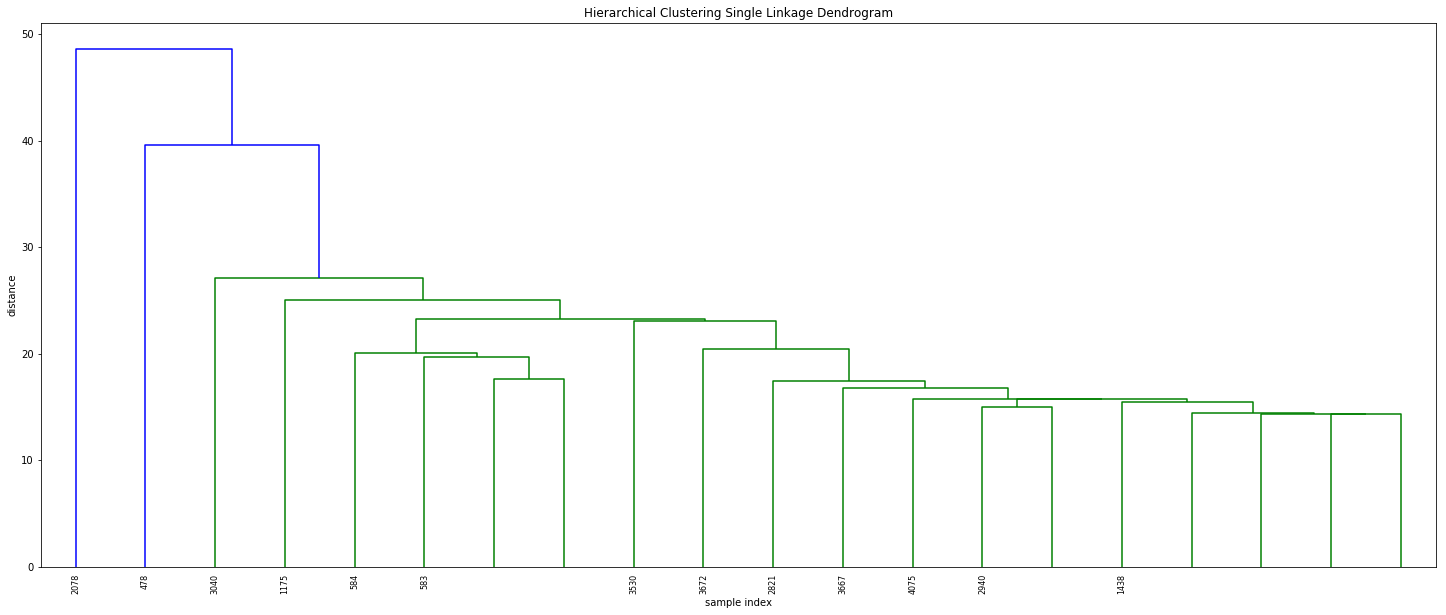

In [96]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Single Linkage Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    shap_mlp_explanations_aggcl_sl,
    truncate_mode = 'lastp',  # show only the last p merged clusters
    p = 20,
    show_leaf_counts = False,  # otherwise numbers in brackets are counts
    show_contracted = False,  # to get a distribution impression in truncated branches
    leaf_rotation = 90.,  # rotates the x axis labels
    leaf_font_size = 8.,  # font size for the x axis labels
)
plt.show()

In [97]:
shap_mlp_explanations_aggcl_sl[-20:-1]

array([[ 4182.        , 10890.        ,    13.97803552,  5347.        ],
       [10868.        , 10891.        ,    14.32089623,  5349.        ],
       [10886.        , 10892.        ,    14.33813213,  5392.        ],
       [10889.        , 10893.        ,    14.37742327,  5396.        ],
       [ 2940.        , 10872.        ,    14.96034095,    31.        ],
       [ 1438.        , 10894.        ,    15.49373629,  5397.        ],
       [10895.        , 10896.        ,    15.6996198 ,  5428.        ],
       [ 4075.        , 10897.        ,    15.7172756 ,  5429.        ],
       [ 3667.        , 10898.        ,    16.76375307,  5430.        ],
       [ 2821.        , 10899.        ,    17.45965067,  5431.        ],
       [10861.        , 10883.        ,    17.62596203,    17.        ],
       [  583.        , 10901.        ,    19.69695438,    18.        ],
       [  584.        , 10902.        ,    20.02709865,    19.        ],
       [ 3672.        , 10900.        ,    20.39212

In [98]:
from scipy.cluster.hierarchy import fcluster
k = 5
shap_mlp_explanations_aggcl_sl_results = fcluster(shap_mlp_explanations_aggcl_sl, k, criterion = 'maxclust')
shap_mlp_explanations_aggcl_sl_results

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [99]:
shap_mlp_explanations_aggcl_sl_classes = pd.DataFrame(shap_mlp_explanations_aggcl_sl_results)
shap_mlp_explanations_aggcl_sl_classes[0].value_counts()

1    5452
3       1
2       1
5       1
4       1
Name: 0, dtype: int64

In [100]:
sampled_object_df['MLP_Pred'].value_counts()

0    5328
2      44
1      33
3      32
4      19
Name: MLP_Pred, dtype: int64

## Clustering on LIME Explanations
[[Back to the top]](#Overview)

### LIME and XGB
[[Back to the top]](#Overview)

<b>1. Using KMeans Clustering:

In [101]:
scaled_lime_xgb_explanations.iloc[:,:-1].head().columns

Index(['volt_lime', 'rotate_lime', 'pressure_lime', 'vibration_lime',
       'volt_mean_24h_lime', 'rotate_mean_24h_lime', 'pressure_mean_24h_lime',
       'vibration_mean_24h_lime', 'volt_std_24h_lime', 'rotate_std_24h_lime',
       'pressure_std_24h_lime', 'vibration_std_24h_lime',
       'error1_sum_24h_lime', 'error2_sum_24h_lime', 'error3_sum_24h_lime',
       'error4_sum_24h_lime', 'error5_sum_24h_lime', 'model_lime', 'age_lime'],
      dtype='object')

In [102]:
#Model definition
from sklearn.cluster import KMeans
lime_xgb_explanations_kmeans = KMeans(n_clusters = 5,
                              init = 'k-means++',
                              n_init = 10,
                              max_iter = 300,
                              tol = 0.0001,
                              precompute_distances = 'auto',
                              verbose = 1,
                              random_state = 7,
                              copy_x = True,
                              n_jobs = -1,
                              algorithm = 'auto')

In [103]:
%%time
#Applying the above model to the scaled_lime_xgb_explanations
lime_xgb_explanations_kmeans_results = lime_xgb_explanations_kmeans.fit(scaled_lime_xgb_explanations.iloc[:,:-1])

Wall time: 7.56 s


In [104]:
#lime_xgb_explanations_kmeans_results.cluster_centers_

In [105]:
lime_xgb_explanations_kmeans_classes = pd.DataFrame(lime_xgb_explanations_kmeans_results.labels_)
lime_xgb_explanations_kmeans_classes[0].value_counts()

0    213087
1      1490
3      1198
2      1184
4      1156
Name: 0, dtype: int64

In [106]:
object_df['XGB_Pred_SKL'].value_counts()

0    213059
2      1580
3      1165
1      1162
4      1149
Name: XGB_Pred_SKL, dtype: int64

<b>2. Using KMeans without random initialization Clustering:

In [107]:
#Computing the average cluster centers for each label class as cluster centers
explan_avg_class0 = scaled_lime_xgb_explanations.iloc[list(object_df[object_df['XGB_Pred'] == 0].index)].mean().values
explan_avg_class1 = scaled_lime_xgb_explanations.iloc[list(object_df[object_df['XGB_Pred'] == 1].index)].mean().values
explan_avg_class2 = scaled_lime_xgb_explanations.iloc[list(object_df[object_df['XGB_Pred'] == 2].index)].mean().values
explan_avg_class3 = scaled_lime_xgb_explanations.iloc[list(object_df[object_df['XGB_Pred'] == 3].index)].mean().values
explan_avg_class4 = scaled_lime_xgb_explanations.iloc[list(object_df[object_df['XGB_Pred'] == 4].index)].mean().values

#Adding all five centroids to an array
xgb_lime_init = np.vstack((explan_avg_class0,explan_avg_class1, explan_avg_class2,explan_avg_class3,explan_avg_class4))
xgb_lime_init = xgb_lime_init[:,:-1]
xgb_lime_init.shape

(5, 19)

In [108]:
#Model definition
from sklearn.cluster import KMeans
lime_xgb_explanations_kmeans_init = KMeans(n_clusters = 5,
                              init = xgb_lime_init,
                              n_init = 10,
                              max_iter = 300,
                              tol = 0.0001,
                              precompute_distances = 'auto',
                              verbose = 1,
                              random_state = 777,
                              copy_x = True,
                              n_jobs = -1,
                              algorithm = 'auto')

In [109]:
%%time
#Applying the above model to the scaled_lime_xgb_explanations 
lime_xgb_explanations_kmeans_init_results = lime_xgb_explanations_kmeans_init.fit(scaled_lime_xgb_explanations.iloc[:,:-1])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Wall time: 1.7 s


In [110]:
#lime_xgb_explanations_kmeans_init_results.cluster_centers_

In [111]:
lime_xgb_explanations_kmeans_init_classes = pd.DataFrame(lime_xgb_explanations_kmeans_init_results.labels_)
lime_xgb_explanations_kmeans_init_classes[0].value_counts()

0    213087
2      1507
4      1186
1      1179
3      1156
Name: 0, dtype: int64

In [112]:
object_df['XGB_Pred_SKL'].value_counts()

0    213059
2      1580
3      1165
1      1162
4      1149
Name: XGB_Pred_SKL, dtype: int64

### LIME and MLP
[[Back to the top]](#Overview)

<b>1. Using KMeans Clustering:

In [113]:
scaled_lime_mlp_explanations.iloc[:,:-1].head().columns

Index(['volt_lime', 'rotate_lime', 'pressure_lime', 'vibration_lime',
       'volt_mean_24h_lime', 'rotate_mean_24h_lime', 'pressure_mean_24h_lime',
       'vibration_mean_24h_lime', 'volt_std_24h_lime', 'rotate_std_24h_lime',
       'pressure_std_24h_lime', 'vibration_std_24h_lime',
       'error1_sum_24h_lime', 'error2_sum_24h_lime', 'error3_sum_24h_lime',
       'error4_sum_24h_lime', 'error5_sum_24h_lime', 'model_lime', 'age_lime'],
      dtype='object')

In [114]:
#Model definition
from sklearn.cluster import KMeans
lime_mlp_explanations_kmeans = KMeans(n_clusters = 5,
                              init = 'k-means++',
                              n_init = 10,
                              max_iter = 300,
                              tol = 0.0001,
                              precompute_distances = 'auto',
                              verbose = 1,
                              random_state = 777,
                              copy_x = True,
                              n_jobs = -1,
                              algorithm = 'auto')

In [115]:
#Applying the above model to the scaled_lime_mlp_explanations
lime_mlp_explanations_kmeans_results = lime_mlp_explanations_kmeans.fit(scaled_lime_mlp_explanations.iloc[:,:-1])

In [116]:
#lime_mlp_explanations_kmeans_results.cluster_centers_

In [117]:
lime_mlp_explanations_kmeans_classes = pd.DataFrame(lime_mlp_explanations_kmeans_results.labels_)
lime_mlp_explanations_kmeans_classes[0].value_counts()

0    5327
3      43
4      34
1      30
2      22
Name: 0, dtype: int64

In [118]:
sampled_object_df['MLP_Pred'].value_counts()

0    5328
2      44
1      33
3      32
4      19
Name: MLP_Pred, dtype: int64

<b>2. Using KMeans Clustering without random initialization:

In [119]:
#Computing the average cluster centers for each label class as cluster centers
explan_avg_class0 = scaled_lime_mlp_explanations.iloc[list(sampled_object_df[sampled_object_df['XGB_Pred'] == 0].index)].mean().values
explan_avg_class1 = scaled_lime_mlp_explanations.iloc[list(sampled_object_df[sampled_object_df['XGB_Pred'] == 1].index)].mean().values
explan_avg_class2 = scaled_lime_mlp_explanations.iloc[list(sampled_object_df[sampled_object_df['XGB_Pred'] == 2].index)].mean().values
explan_avg_class3 = scaled_lime_mlp_explanations.iloc[list(sampled_object_df[sampled_object_df['XGB_Pred'] == 3].index)].mean().values
explan_avg_class4 = scaled_lime_mlp_explanations.iloc[list(sampled_object_df[sampled_object_df['XGB_Pred'] == 4].index)].mean().values

#Adding all five centroids to an array
mlp_lime_init = np.vstack((explan_avg_class0,explan_avg_class1, explan_avg_class2,explan_avg_class3,explan_avg_class4))
mlp_lime_init = mlp_lime_init[:,:-1]
mlp_lime_init.shape

(5, 19)

In [120]:
#Model definition
from sklearn.cluster import KMeans
lime_mlp_explanations_kmeans_init = KMeans(n_clusters = 5,
                              init = mlp_lime_init,
                              n_init = 10,
                              max_iter = 300,
                              tol = 0.0001,
                              precompute_distances = 'auto',
                              verbose = 1,
                              random_state = 777,
                              copy_x = True,
                              n_jobs = -1,
                              algorithm = 'auto')

In [121]:
%%time
#Applying the above model to the scaled_lime_xgb_explanations 
lime_mlp_explanations_kmeans_init_results = lime_mlp_explanations_kmeans_init.fit(scaled_lime_mlp_explanations.iloc[:,:-1])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Wall time: 1.38 s


In [122]:
#lime_mlp_explanations_kmeans_init_results.cluster_centers_

In [123]:
lime_mlp_explanations_kmeans_init_classes = pd.DataFrame(lime_mlp_explanations_kmeans_init_results.labels_)
lime_mlp_explanations_kmeans_init_classes[0].value_counts()

0    5328
2      43
1      33
3      30
4      22
Name: 0, dtype: int64

In [124]:
sampled_object_df['MLP_Pred'].value_counts()

0    5328
2      44
1      33
3      32
4      19
Name: MLP_Pred, dtype: int64

<b>3. Using Agglomerative (Hierarchical) Clustering 1:

In [125]:
scaled_lime_mlp_explanations.iloc[:,:-1].head().columns

Index(['volt_lime', 'rotate_lime', 'pressure_lime', 'vibration_lime',
       'volt_mean_24h_lime', 'rotate_mean_24h_lime', 'pressure_mean_24h_lime',
       'vibration_mean_24h_lime', 'volt_std_24h_lime', 'rotate_std_24h_lime',
       'pressure_std_24h_lime', 'vibration_std_24h_lime',
       'error1_sum_24h_lime', 'error2_sum_24h_lime', 'error3_sum_24h_lime',
       'error4_sum_24h_lime', 'error5_sum_24h_lime', 'model_lime', 'age_lime'],
      dtype='object')

In [126]:
from sklearn.cluster import AgglomerativeClustering
lime_mlp_explanations_aggcl = AgglomerativeClustering(n_clusters = 5,
                                                      affinity = 'euclidean',
                                                      memory = None,
                                                      connectivity = None,
                                                      compute_full_tree = 'auto',
                                                      linkage = 'ward',
                                                      pooling_func = np.mean)

In [127]:
#Applying the above model to the scaled_sampled_object_df_1h 
lime_mlp_explanations_aggcl_results = lime_mlp_explanations_aggcl.fit(scaled_lime_mlp_explanations.iloc[:,:-1])

In [128]:
#sampled_object_df_kmeans_results.cluster_centers_

In [129]:
lime_mlp_explanations_aggcl_classes = pd.DataFrame(lime_mlp_explanations_aggcl_results.labels_)
lime_mlp_explanations_aggcl_classes[0].value_counts()

1    5316
2      43
0      43
4      34
3      20
Name: 0, dtype: int64

In [130]:
sampled_object_df['MLP_Pred'].value_counts()

0    5328
2      44
1      33
3      32
4      19
Name: MLP_Pred, dtype: int64

<b>4. Using Agglomerative (Hierarchical) Clustering 2:

In [131]:
from scipy.cluster.hierarchy import dendrogram, linkage
lime_mlp_explanations_aggcl_sl = linkage(scaled_lime_mlp_explanations.iloc[:,:-1], 'single')

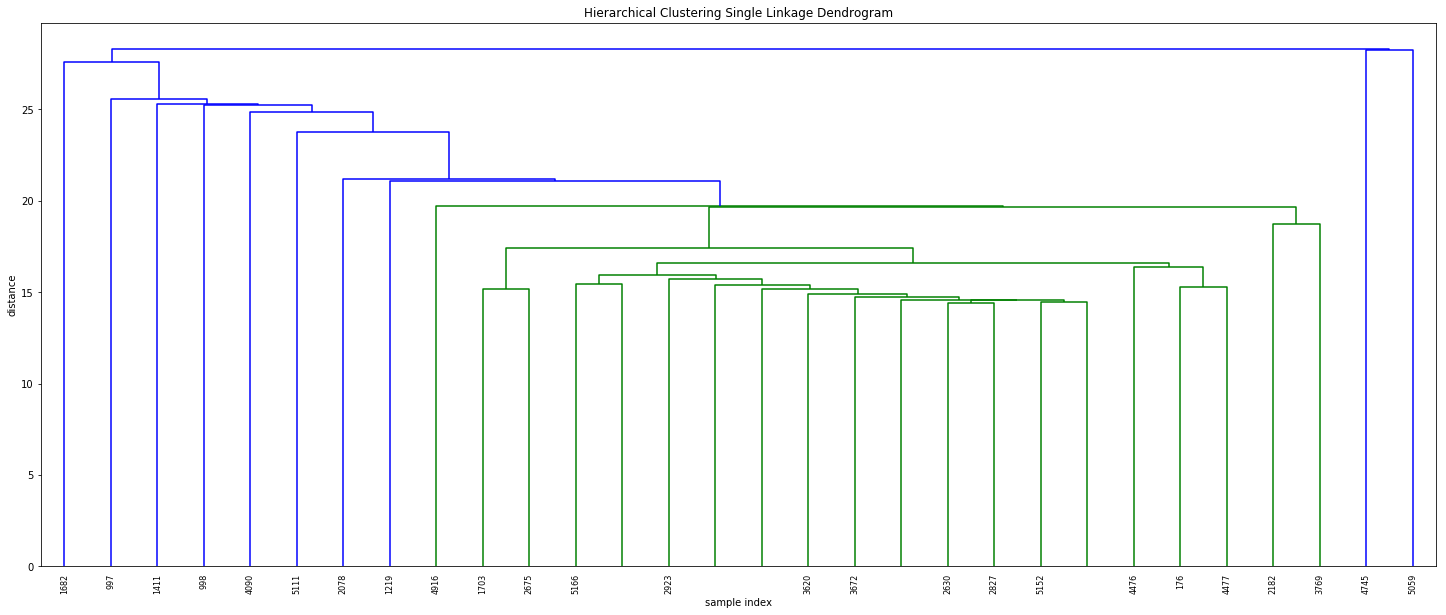

In [132]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Single Linkage Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    lime_mlp_explanations_aggcl_sl,
    truncate_mode = 'lastp',  # show only the last p merged clusters
    #p = 20,
    show_leaf_counts = False,  # otherwise numbers in brackets are counts
    show_contracted = False,  # to get a distribution impression in truncated branches
    leaf_rotation = 90.,  # rotates the x axis labels
    leaf_font_size = 8.,  # font size for the x axis labels
)
plt.show()

In [133]:
lime_mlp_explanations_aggcl_sl[-20:-1]

array([[10865.        , 10888.        ,    15.41591376,  5434.        ],
       [ 5166.        , 10874.        ,    15.42582522,     3.        ],
       [ 2923.        , 10891.        ,    15.72726141,  5435.        ],
       [10892.        , 10893.        ,    15.91550427,  5438.        ],
       [ 4476.        , 10890.        ,    16.35992876,     3.        ],
       [10894.        , 10895.        ,    16.61614768,  5441.        ],
       [10889.        , 10896.        ,    17.43861847,  5443.        ],
       [ 2182.        ,  3769.        ,    18.72821015,     2.        ],
       [10897.        , 10898.        ,    19.66270885,  5445.        ],
       [ 4916.        , 10899.        ,    19.68597562,  5446.        ],
       [ 1219.        , 10900.        ,    21.05740457,  5447.        ],
       [ 2078.        , 10901.        ,    21.19137227,  5448.        ],
       [ 5111.        , 10902.        ,    23.7304267 ,  5449.        ],
       [ 4090.        , 10903.        ,    24.85491

In [134]:
from scipy.cluster.hierarchy import fcluster
k = 5
lime_mlp_explanations_aggcl_sl_results = fcluster(lime_mlp_explanations_aggcl_sl, k, criterion = 'maxclust')
lime_mlp_explanations_aggcl_sl_results

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [135]:
lime_mlp_explanations_aggcl_sl_classes = pd.DataFrame(lime_mlp_explanations_aggcl_sl_results)
lime_mlp_explanations_aggcl_sl_classes[0].value_counts()

1    5452
3       1
2       1
5       1
4       1
Name: 0, dtype: int64

In [136]:
sampled_object_df['MLP_Pred'].value_counts()

0    5328
2      44
1      33
3      32
4      19
Name: MLP_Pred, dtype: int64

## Cluster Similarity Analysis
[[Back to the top]](#Overview)

This is the section where we test the entire concept with the previously established criteria. This means that we cluster objects which are similar and the corresponding clusters of similar explanations. What we want to test now is whether similar objects (i.e. that belong to the same clusters) also have similar explanations (i.e. are in the same cluster). As an exmaple, if one cluster contains 10 similar objecst, we would hope that the 10 corresponding explanations to those objects also belong to the same (explanation) cluster, without more or less explanations in the ideal case. More realistical than to say that all objects in a cluster must have all corresponding explanations in the same explanation cluster is to simply calculate how similar the clusters are.

Thus, in the following we will define a function that takes two separate dataframes with the results of the object clustering and the explanation clustering and determines for each object cluster the most similar explanation cluster (i.e. the explanation cluster that contains the most corresponding explanations of the objects that are contained in that object cluster).

This function is based on the jaccard-coefficient and will be used throughout the following subsections.

In [137]:
from math import*
#Defining the jaccard_similarity to compute similarities between the clusters
def jaccard_similarity(x, y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality / float(union_cardinality)

#Creating a function that computes the most similar clusters comparing objects and explanations
def compute_cluster_similarities(object_clustering_df, explanation_clustering_df):
    '''This function has 2 arguments:
    - object_clustering_df = dataframe with index and in the first column the assigned cluster to that object
    - explanation_clustering_df: corresponding explanation df with clusters for each object in the df above
    return value is a dictionary, which assigns to each object cluster the most similar explanation cluster.
    Note: the #Clusters must be equal in each dataframe.'''
    
    #First we must determine the number of clusters in either of the two df in the arguments
    nclusters = len(object_clustering_df.iloc[:,0].unique())
    
    #This function creates a list of lists, whereas each sublist contains the indices of all objects in that cluster
    objects_list = list()
    explanations_list = list()
    for cluster in range(nclusters):
        objects_list.append(list(object_clustering_df[object_clustering_df.iloc[:,0] == cluster].index)) 
        explanations_list.append(list(explanation_clustering_df[explanation_clustering_df.iloc[:,0] == cluster].index))
    
    #This function computes the jaccard_similarities for all cluster combinations
    js_similarities = dict()
    for i in range(nclusters):
        for j in range(nclusters):
            js_similarities[i,j] = jaccard_similarity(objects_list[i], explanations_list[j])
    
    #This function determines which clusters have the highest similarity amongst each other
    cluster_similarities = dict()
    max_probab = 0
    a_helper = 0
    b_helper = 0
    for i in range(nclusters):
        for j in range(nclusters):
            if js_similarities[i,j] > max_probab:
                max_probab = js_similarities[i,j]
                a_helper = i
                b_helper = j
        cluster_similarities[a_helper, b_helper] = max_probab
        max_probab = 0
    
    #Return the dictionary which contains the clusters with the highest similarities
    return cluster_similarities

In [138]:
def average(float_dict):
    values = float_dict.values()
    values = list(values)
    length = len(values)
    list_sum = sum(values)
    return (list_sum / length)

In [139]:
def weighted_average(float_dict, cluster_df):
    cluster_cardinalities = list(cluster_df.iloc[:,0].value_counts())
    number_of_objects = sum(cluster_cardinalities)
    values = float_dict.values()
    values = list(values)
    weighted_average = 0
    i = 0
    for entry in values:
        #print(entry)
        weighted_average = weighted_average + entry * cluster_cardinalities[i] / number_of_objects
        i += 1
    return weighted_average

### shap_xgb and object_df
[[Back to the top]](#Overview)

<b>Test of Identity Axiom:

In [140]:
object_df.iloc[:,2:22].duplicated().value_counts()

False    218115
dtype: int64

In [141]:
oks = object_df.iloc[:,2:22].duplicated().value_counts()[False]
oks

218115

In [142]:
errors = len(object_df.iloc[:,2:22]) - oks
errors

0

In [143]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 1 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 218115 Erorrs: 0

Axiom 1 Stats:
Fulfilled in: 218115 Cases
Not fulfilled in: 0 Cases
Relative Fulfillment: 100.0 %


<b>Test of Separability Axiom:

In [144]:
scaled_shap_xgb_explanations.duplicated().value_counts()

False    217803
True        312
dtype: int64

In [145]:
oks = scaled_shap_xgb_explanations.duplicated().value_counts()[False]
oks

217803

In [146]:
errors = scaled_shap_xgb_explanations.duplicated().value_counts()[True]
errors

312

In [147]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 2 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 217803 Erorrs: 312

Axiom 2 Stats:
Fulfilled in: 217803 Cases
Not fulfilled in: 312 Cases
Relative Fulfillment: 99.85675128441757 %


<b>Test of Stability Axiom:

<b>1. Using KMeans Clustering:

In [148]:
compute_cluster_similarities(pd.DataFrame(object_df['XGB_Pred']), shap_xgb_explanations_kmeans_classes)

{(0, 0): 0.8589754358457461,
 (1, 0): 0.0060219834773177355,
 (2, 4): 0.9578881206788183,
 (3, 3): 0.9929140832595217,
 (4, 1): 1.0}

In [149]:
from sklearn.metrics import calinski_harabaz_score
calinski_harabaz_score(scaled_shap_xgb_explanations.iloc[:,:-1], shap_xgb_explanations_kmeans_classes[0])

31900.880381663203

<b>2. Using KMeans Clustering without random initialization:

In [150]:
cs_shap_xgb = compute_cluster_similarities(pd.DataFrame(object_df['XGB_Pred']), shap_xgb_explanations_kmeans_init_classes)
cs_shap_xgb

{(0, 0): 0.9992591585353846,
 (1, 1): 0.9296013570822731,
 (2, 2): 0.9578881206788183,
 (3, 3): 0.9929140832595217,
 (4, 4): 1.0}

In [151]:
from sklearn.metrics import calinski_harabaz_score
calinski_harabaz_score(scaled_shap_xgb_explanations.iloc[:,:-1], shap_xgb_explanations_kmeans_init_classes[0])

34700.87647120932

As we can see above, the Calinski-Harabaz score is higher in the second case (without random initialization), which means that it is better, as 'a higher Calinski-Harabaz score relates to a model with better defined clusters'
<p><b>Note:</b> the score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster
<br><b>Explanation:</b> the Calinski-Harabaz score s is given as the ratio of the between-clusters dispersion mean and the within-cluster dispersion
<br><b>Source:</b> http://scikit-learn.org/stable/modules/clustering.html#calinski-harabaz-index

In [152]:
weighted_average(cs_shap_xgb, shap_xgb_explanations_kmeans_init_classes)

0.9985314594838025

In [153]:
average(cs_shap_xgb)

0.9759325439111995

In [154]:
object_clusters = pd.DataFrame(object_df['XGB_Pred'])["XGB_Pred"].value_counts()
object_clusters

0    213113
2      1591
1      1179
3      1129
4      1103
Name: XGB_Pred, dtype: int64

In [155]:
explanation_clusters = shap_xgb_explanations_kmeans_init_classes[0].value_counts()
explanation_clusters

0    213271
2      1524
3      1121
4      1103
1      1096
Name: 0, dtype: int64

In [156]:
object_clusters.sum()

218115

In [157]:
errors = abs(object_clusters - explanation_clusters).sum()
errors

316

In [158]:
oks = (object_clusters.sum() - errors)
oks

217799

In [159]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 3 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 217799 Erorrs: 316

Axiom 3 Stats:
Fulfilled in: 217799 Cases
Not fulfilled in: 316 Cases
Relative Fulfillment: 99.8549120978517 %


### shap_mlp and sampled_object_df
[[Back to the top]](#Overview)

<b>Test of Identity Axiom:

In [160]:
sampled_object_df.iloc[:,2:22].duplicated().value_counts()

False    5456
dtype: int64

In [161]:
oks = sampled_object_df.iloc[:,2:22].duplicated().value_counts()[False]
oks

5456

In [162]:
errors = len(sampled_object_df.iloc[:,2:22]) - oks
errors

0

In [163]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 1 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 5456 Erorrs: 0

Axiom 1 Stats:
Fulfilled in: 5456 Cases
Not fulfilled in: 0 Cases
Relative Fulfillment: 100.0 %


<b>Test of Separability Axiom:

In [164]:
scaled_shap_mlp_explanations.duplicated().value_counts()

False    5456
dtype: int64

In [165]:
oks = scaled_shap_mlp_explanations.duplicated().value_counts()[False]
oks

5456

In [166]:
errors = (scaled_shap_mlp_explanations.duplicated().value_counts().sum() - oks)
errors

0

In [167]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 2 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 5456 Erorrs: 0

Axiom 2 Stats:
Fulfilled in: 5456 Cases
Not fulfilled in: 0 Cases
Relative Fulfillment: 100.0 %


<b>Test of Stability Axiom:

<b>1. Using KMeans Clustering:

In [168]:
compute_cluster_similarities(pd.DataFrame(sampled_object_df['MLP_Pred']), shap_mlp_explanations_kmeans_classes)

{(0, 0): 0.99981234753237,
 (1, 4): 0.9696969696969697,
 (2, 2): 1.0,
 (3, 1): 1.0,
 (4, 3): 1.0}

In [169]:
from sklearn.metrics import calinski_harabaz_score
calinski_harabaz_score(scaled_shap_mlp_explanations.iloc[:,:-1], shap_mlp_explanations_kmeans_classes[0])

1282.8288704418876

<b>2. Using KMeans Clustering without random initialization:

In [170]:
cs_shap_mlp = compute_cluster_similarities(pd.DataFrame(sampled_object_df['MLP_Pred']), shap_mlp_explanations_kmeans_init_classes)
cs_shap_mlp

{(0, 0): 0.99981234753237,
 (1, 1): 0.9696969696969697,
 (2, 2): 1.0,
 (3, 3): 1.0,
 (4, 4): 1.0}

In [171]:
from sklearn.metrics import calinski_harabaz_score
calinski_harabaz_score(scaled_shap_mlp_explanations.iloc[:,:-1], shap_mlp_explanations_kmeans_init_classes[0])

1282.8288704418876

In [172]:
weighted_average(cs_shap_mlp, shap_mlp_explanations_kmeans_init_classes)

0.9995723362658847

In [173]:
average(cs_shap_mlp)

0.9939018634458681

In [174]:
object_clusters = pd.DataFrame(sampled_object_df['MLP_Pred'])["MLP_Pred"].value_counts()
object_clusters

0    5328
2      44
1      33
3      32
4      19
Name: MLP_Pred, dtype: int64

In [175]:
explanation_clusters = shap_mlp_explanations_kmeans_init_classes[0].value_counts()
explanation_clusters

0    5329
2      44
3      32
1      32
4      19
Name: 0, dtype: int64

In [176]:
object_clusters.sum()

5456

In [177]:
errors = abs(object_clusters - explanation_clusters).sum()
errors

2

In [178]:
oks = (object_clusters.sum() - errors)
oks

5454

In [179]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 3 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 5454 Erorrs: 2

Axiom 3 Stats:
Fulfilled in: 5454 Cases
Not fulfilled in: 2 Cases
Relative Fulfillment: 99.96332966629996 %


<b>3. Using Agglomerative (Hierarchical) Clustering 1:

In [180]:
cs_shap_mlp = compute_cluster_similarities(pd.DataFrame(sampled_object_df['MLP_Pred']), shap_mlp_explanations_aggcl_classes)
cs_shap_mlp

{(0, 0): 0.99981234753237,
 (1, 1): 0.9696969696969697,
 (2, 3): 1.0,
 (3, 4): 1.0,
 (4, 2): 1.0}

In [181]:
from sklearn.metrics import calinski_harabaz_score
calinski_harabaz_score(scaled_shap_mlp_explanations.iloc[:,:-1], shap_mlp_explanations_aggcl_classes[0])

1282.8288704418876

In [182]:
shap_mlp_new_agll_cluster = shap_mlp_explanations_aggcl_classes.copy()

In [183]:
helper_list = list()
for entry in shap_mlp_new_agll_cluster[0]:
    if entry == 0: helper_list.append(0)
    if entry == 1: helper_list.append(1)
    if entry == 2: helper_list.append(4)
    if entry == 3: helper_list.append(2)
    if entry == 4: helper_list.append(3)
shap_mlp_new_agll_cluster['new_cluster_names'] = helper_list
shap_mlp_new_agll_cluster['new_cluster_names'].value_counts()

0    5329
2      44
3      32
1      32
4      19
Name: new_cluster_names, dtype: int64

In [184]:
cs_shap_mlp = compute_cluster_similarities(pd.DataFrame(sampled_object_df['MLP_Pred']), pd.DataFrame(shap_mlp_new_agll_cluster['new_cluster_names']))
cs_shap_mlp

{(0, 0): 0.99981234753237,
 (1, 1): 0.9696969696969697,
 (2, 2): 1.0,
 (3, 3): 1.0,
 (4, 4): 1.0}

In [185]:
object_clusters = pd.DataFrame(sampled_object_df['MLP_Pred'])["MLP_Pred"].value_counts()
object_clusters

0    5328
2      44
1      33
3      32
4      19
Name: MLP_Pred, dtype: int64

In [186]:
explanation_clusters = shap_mlp_new_agll_cluster['new_cluster_names'].value_counts()
explanation_clusters

0    5329
2      44
3      32
1      32
4      19
Name: new_cluster_names, dtype: int64

In [187]:
object_clusters.sum()

5456

In [188]:
errors = abs(object_clusters - explanation_clusters).sum()
errors

2

In [189]:
oks = (object_clusters.sum() - errors)
oks

5454

In [190]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 3 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 5454 Erorrs: 2

Axiom 3 Stats:
Fulfilled in: 5454 Cases
Not fulfilled in: 2 Cases
Relative Fulfillment: 99.96332966629996 %


<b>4. Using Agglomerative (Hierarchical) Clustering 2:

In [191]:
compute_cluster_similarities(pd.DataFrame(sampled_object_df['MLP_Pred']), shap_mlp_explanations_aggcl_sl_classes)

{(0, 1): 0.9765309864319766,
 (1, 4): 0.030303030303030304,
 (2, 2): 0.022727272727272728,
 (3, 1): 0.00586940572267058,
 (4, 1): 0.003484959647835657}

In [192]:
from sklearn.metrics import calinski_harabaz_score
calinski_harabaz_score(scaled_shap_mlp_explanations.iloc[:,:-1], shap_mlp_explanations_aggcl_sl_classes[0])

149.46111251382132

### lime_xgb and object_df
[[Back to the top]](#Overview)

<b>Test of Identity Axiom:

In [193]:
object_df.iloc[:,2:22].duplicated().value_counts()

False    218115
dtype: int64

In [194]:
oks = object_df.iloc[:,2:22].duplicated().value_counts()[False]
oks

218115

In [195]:
errors = len(object_df.iloc[:,2:22]) - oks
errors

0

In [196]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 1 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 218115 Erorrs: 0

Axiom 1 Stats:
Fulfilled in: 218115 Cases
Not fulfilled in: 0 Cases
Relative Fulfillment: 100.0 %


<b>Test of Separability Axiom:

In [197]:
scaled_lime_xgb_explanations.duplicated().value_counts()

False    195952
True      22163
dtype: int64

In [198]:
oks = scaled_lime_xgb_explanations.duplicated().value_counts()[False]
oks

195952

In [199]:
errors = scaled_lime_xgb_explanations.duplicated().value_counts()[True]
errors

22163

In [200]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 2 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 195952 Erorrs: 22163

Axiom 2 Stats:
Fulfilled in: 195952 Cases
Not fulfilled in: 22163 Cases
Relative Fulfillment: 88.68957703927492 %


<b>Test of Stability Axiom:

<b>1. Using KMeans Clustering:

In [201]:
compute_cluster_similarities(pd.DataFrame(object_df['XGB_Pred_SKL']), lime_xgb_explanations_kmeans_classes)

{(0, 0): 0.999840443005303,
 (1, 2): 0.9245283018867925,
 (2, 1): 0.9259723964868256,
 (3, 4): 0.9736394557823129,
 (4, 3): 0.9096826688364524}

In [202]:
from sklearn.metrics import calinski_harabaz_score
calinski_harabaz_score(scaled_lime_xgb_explanations.iloc[:,:-1], lime_xgb_explanations_kmeans_classes[0])

83774.00016266729

<b>2. Using KMeans Clustering without random initialization:

In [203]:
cs_lime_xgb = compute_cluster_similarities(pd.DataFrame(object_df['XGB_Pred_SKL']), lime_xgb_explanations_kmeans_init_classes)
cs_lime_xgb

{(0, 0): 0.999840443005303,
 (1, 1): 0.9251644736842105,
 (2, 2): 0.9269662921348315,
 (3, 3): 0.9736394557823129,
 (4, 4): 0.9092395748160261}

In [204]:
from sklearn.metrics import calinski_harabaz_score
calinski_harabaz_score(scaled_lime_xgb_explanations.iloc[:,:-1], lime_xgb_explanations_kmeans_init_classes[0])

83772.67691810487

In [205]:
weighted_average(cs_lime_xgb, lime_xgb_explanations_kmeans_init_classes)

0.998306431147971

In [206]:
average(cs_lime_xgb)

0.9469700478845369

In [207]:
object_clusters = pd.DataFrame(object_df['XGB_Pred_SKL'])['XGB_Pred_SKL'].value_counts()
object_clusters

0    213059
2      1580
3      1165
1      1162
4      1149
Name: XGB_Pred_SKL, dtype: int64

In [208]:
explanation_clusters = lime_xgb_explanations_kmeans_init_classes[0].value_counts()
explanation_clusters

0    213087
2      1507
4      1186
1      1179
3      1156
Name: 0, dtype: int64

In [209]:
object_clusters.sum()

218115

In [210]:
errors = abs(object_clusters - explanation_clusters).sum()
errors

164

In [211]:
oks = (object_clusters.sum() - errors)
oks

217951

In [212]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 3 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 217951 Erorrs: 164

Axiom 3 Stats:
Fulfilled in: 217951 Cases
Not fulfilled in: 164 Cases
Relative Fulfillment: 99.92475372904919 %


### lime_mlp and sampled_object_df
[[Back to the top]](#Overview)

<b>Test of Identity Axiom:

In [213]:
sampled_object_df.iloc[:,2:22].duplicated().value_counts()

False    5456
dtype: int64

In [214]:
oks = sampled_object_df.iloc[:,2:22].duplicated().value_counts()[False]
oks

5456

In [215]:
errors = len(sampled_object_df.iloc[:,2:22]) - oks
errors

0

In [216]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 1 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 5456 Erorrs: 0

Axiom 1 Stats:
Fulfilled in: 5456 Cases
Not fulfilled in: 0 Cases
Relative Fulfillment: 100.0 %


<b>Test of Separability Axiom:

In [217]:
scaled_lime_mlp_explanations.duplicated().value_counts()

False    5456
dtype: int64

In [218]:
oks = scaled_lime_mlp_explanations.duplicated().value_counts()[False]
oks

5456

In [219]:
errors = (scaled_lime_mlp_explanations.duplicated().value_counts().sum() - oks)
errors

0

In [220]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 2 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 5456 Erorrs: 0

Axiom 2 Stats:
Fulfilled in: 5456 Cases
Not fulfilled in: 0 Cases
Relative Fulfillment: 100.0 %


<b>Test of Stability Axiom:

<b>1. Using KMeans Clustering:

In [221]:
compute_cluster_similarities(pd.DataFrame(sampled_object_df['MLP_Pred']), lime_mlp_explanations_kmeans_classes)

{(0, 0): 0.99906191369606,
 (1, 1): 0.8,
 (2, 3): 0.9333333333333333,
 (3, 4): 0.8857142857142857,
 (4, 2): 0.782608695652174}

In [222]:
from sklearn.metrics import calinski_harabaz_score
calinski_harabaz_score(scaled_lime_mlp_explanations.iloc[:,:-1], lime_mlp_explanations_kmeans_classes[0])

1180.3928062525938

<b>2. Using KMeans Clustering without random initialization:

In [223]:
cs_lime_mlp = compute_cluster_similarities(pd.DataFrame(sampled_object_df['MLP_Pred']), lime_mlp_explanations_kmeans_init_classes)
cs_lime_mlp

{(0, 0): 0.9988745075970737,
 (1, 1): 0.7368421052631579,
 (2, 2): 0.9333333333333333,
 (3, 3): 0.9375,
 (4, 4): 0.782608695652174}

In [224]:
from sklearn.metrics import calinski_harabaz_score
calinski_harabaz_score(scaled_lime_mlp_explanations.iloc[:,:-1], lime_mlp_explanations_kmeans_init_classes[0])

1179.8865826822093

In [225]:
weighted_average(cs_lime_mlp, lime_mlp_explanations_kmeans_init_classes)

0.9952034417719707

In [226]:
average(cs_lime_mlp)

0.8778317283691477

In [227]:
object_clusters = pd.DataFrame(sampled_object_df['MLP_Pred'])['MLP_Pred'].value_counts()
object_clusters

0    5328
2      44
1      33
3      32
4      19
Name: MLP_Pred, dtype: int64

In [228]:
explanation_clusters = lime_mlp_explanations_kmeans_init_classes[0].value_counts()
explanation_clusters

0    5328
2      43
1      33
3      30
4      22
Name: 0, dtype: int64

In [229]:
object_clusters.sum()

5456

In [230]:
errors = abs(object_clusters - explanation_clusters).sum()
errors

6

In [231]:
oks = (object_clusters.sum() - errors)
oks

5450

In [232]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 3 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 5450 Erorrs: 6

Axiom 3 Stats:
Fulfilled in: 5450 Cases
Not fulfilled in: 6 Cases
Relative Fulfillment: 99.88990825688073 %


<b>3. Using Agglomerative (Hierarchical) Clustering 1:

In [233]:
compute_cluster_similarities(pd.DataFrame(sampled_object_df['MLP_Pred']), lime_mlp_explanations_aggcl_classes)

{(0, 1): 0.9973728654531807,
 (1, 4): 0.5952380952380952,
 (2, 2): 0.8913043478260869,
 (3, 0): 0.5306122448979592,
 (4, 3): 0.7727272727272727}

In [234]:
from sklearn.metrics import calinski_harabaz_score
calinski_harabaz_score(scaled_lime_mlp_explanations.iloc[:,:-1], lime_mlp_explanations_aggcl_classes[0])

1127.9324431569912

In [235]:
lime_mlp_new_agll_cluster = lime_mlp_explanations_aggcl_classes.copy()

In [236]:
helper_list = list()
for entry in lime_mlp_new_agll_cluster[0]:
    if entry == 0: helper_list.append(3)
    if entry == 1: helper_list.append(0)
    if entry == 2: helper_list.append(2)
    if entry == 3: helper_list.append(4)
    if entry == 4: helper_list.append(1)
lime_mlp_new_agll_cluster['new_cluster_names'] = helper_list
lime_mlp_new_agll_cluster['new_cluster_names'].value_counts()

0    5316
3      43
2      43
1      34
4      20
Name: new_cluster_names, dtype: int64

In [237]:
cs_lime_mlp = compute_cluster_similarities(pd.DataFrame(sampled_object_df['MLP_Pred']), pd.DataFrame(lime_mlp_new_agll_cluster['new_cluster_names']))
cs_lime_mlp

{(0, 0): 0.9973728654531807,
 (1, 1): 0.5952380952380952,
 (2, 2): 0.8913043478260869,
 (3, 3): 0.5306122448979592,
 (4, 4): 0.7727272727272727}

In [238]:
object_clusters = pd.DataFrame(sampled_object_df['MLP_Pred'])['MLP_Pred'].value_counts()
object_clusters

0    5328
2      44
1      33
3      32
4      19
Name: MLP_Pred, dtype: int64

In [239]:
explanation_clusters = lime_mlp_new_agll_cluster['new_cluster_names'].value_counts()
explanation_clusters

0    5316
3      43
2      43
1      34
4      20
Name: new_cluster_names, dtype: int64

In [240]:
object_clusters.sum()

5456

In [241]:
errors = abs(object_clusters - explanation_clusters).sum()
errors

26

In [242]:
oks = (object_clusters.sum() - errors)
oks

5430

In [243]:
print('Oks:', oks, 'Erorrs:', errors)
print()
print("Axiom 3 Stats:")
print("Fulfilled in:", oks, "Cases")
print("Not fulfilled in:", errors, "Cases")
print("Relative Fulfillment:", (1 - errors / oks) * 100,"%")

Oks: 5430 Erorrs: 26

Axiom 3 Stats:
Fulfilled in: 5430 Cases
Not fulfilled in: 26 Cases
Relative Fulfillment: 99.52117863720073 %


<b>4. Using Agglomerative (Hierarchical) Clustering with Single Linkage 2:

In [244]:
compute_cluster_similarities(pd.DataFrame(sampled_object_df['MLP_Pred']), lime_mlp_explanations_aggcl_sl_classes)

{(0, 1): 0.9772560528246516,
 (1, 3): 0.030303030303030304,
 (2, 2): 0.022727272727272728,
 (3, 4): 0.03125,
 (4, 1): 0.003300935264991748}

In [245]:
from sklearn.metrics import calinski_harabaz_score
calinski_harabaz_score(scaled_shap_mlp_explanations.iloc[:,:-1], lime_mlp_explanations_aggcl_sl_classes[0])

27.426787693855925